# Delphi inference and evaluation

Welcome to the Delphi evaluation notebook! To run this notebook, you need to have the Delphi model checkpoint. 
Refer to the README for instructions on how to train it on synthetic (or real!) data.

Here, we show how to work with the model, load data and perform inference. We also reproduce some of the figures from the paper.

Note that this notebook in its current state was executed using the original Delphi checkpoint and full UK biobank data. The small synthetic dataset we provide in this repository may not be sufficient to reproduce all the results.

On Mac M1 Pro CPU using the synthetic dataset, the notebook takes ~10 minutes to run.

## Table of contents

1. Loading model
2. Data: structure and loading
3. Inference
4. Prediction of future disease rates
5. Checking calibration of predicted rates
6. Evaluation of AUC
7. Looking into attention patterns
8. Token embedding UMAP



In [1]:
import os
import torch
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi'] = 72
plt.rcParams['pdf.fonttype'] = 42

#Green
light_male = '#BAEBE3'
normal_male = '#0FB8A1'
dark_male = '#00574A'


#Purple
light_female = '#DEC7FF'
normal_female = '#8520F1'
dark_female = '#7A00BF'

 
delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')

In [3]:
# Delphi is capable of predicting the disease risk for 1,256 diseases from ICD-10 plus death. 
# For illustrative purposes, some of the plots will focus on a subset of 10 selected diseases - the same subset in used in the Delphi paper. 

diseases_of_interest = [46, 95, 1168, 1188, 374, 214, 305, 505, 603, 1269]
delphi_labels.iloc[diseases_of_interest][['name', 'ICD-10 Chapter (short)']]

name       ICD-10 Chapter (short)
46                      A41 Other septicaemia       I. Infectious Diseases
95                 B01 Varicella [chickenpox]       I. Infectious Diseases
1168       C25 Malignant neoplasm of pancreas                II. Neoplasms
1188         C50 Malignant neoplasm of breast                II. Neoplasms
374                   G30 Alzheimer's disease  VI. Nervous System Diseases
214   E10 Insulin-dependent diabetes mellitus       IV. Metabolic Diseases
305                    F32 Depressive episode          V. Mental Disorders
505           I21 Acute myocardial infarction     IX. Circulatory Diseases
603                                J45 Asthma      X. Respiratory Diseases
1269                                    Death                        Death

## Load model

In [4]:
out_dir = 'Delphi-2M'
device = 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'mps', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
print(ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)

checkpoint['model_args']

Delphi-2M/ckpt.pt


FileNotFoundError: [Errno 2] No such file or directory: 'Delphi-2M/ckpt.pt'

In [6]:
# Let's try to use the loaded model to extrapolate a partial health trajectory.

example_health_trajectory = [
    ('Male', 0),
    ('B01 Varicella [chickenpox]',2),
    ('L20 Atopic dermatitis',3),
    ('No event', 5),
    ('No event', 10),
    ('No event', 15),
    ('No event', 20),
    ('G43 Migraine', 20),
    ('E73 Lactose intolerance',21),
    ('B27 Infectious mononucleosis',22),
    ('No event', 25),
    ('J11 Influenza, virus not identified',28),
    ('No event', 30),
    ('No event', 35),
    ('No event', 40),
    ('Smoking low', 41),
    ('BMI mid', 41),
    ('Alcohol low', 41),
    ('No event', 42),
]
example_health_trajectory = [(a, b * 365.25) for a,b in example_health_trajectory] 

In [ ]:
max_new_tokens = 100

name_to_token_id = {row[1]['name']: row[1]['index'] for row in delphi_labels.iterrows()}

events = [name_to_token_id[event[0]] for event in example_health_trajectory]
events = torch.tensor(events, device=device).unsqueeze(0)
ages = [event[1] for event in example_health_trajectory]
ages = torch.tensor(ages, device=device).unsqueeze(0)

res = []
with torch.no_grad():
    y,b,_ = model.generate(events, ages, max_new_tokens, termination_tokens=[1269])
    # Convert model outputs to readable format
    events_data = zip(y.cpu().numpy().flatten(), b.cpu().numpy().flatten()/365.)
    
    print('Input trajectory:')
    for i, (event_id, age_years) in enumerate(events_data):
        if i == len(example_health_trajectory):
            print('=====================')
            print('Generated trajectory:')
        event_name = delphi_labels.loc[event_id, 'name']
        print(f"{age_years:2.1f}: {event_name}")

Input trajectory:
0.0: Male
2.0: B01 Varicella [chickenpox]
3.0: L20 Atopic dermatitis
5.0: No event
10.0: No event
15.0: No event
20.0: No event
20.0: G43 Migraine
21.0: E73 Lactose intolerance
22.0: B27 Infectious mononucleosis
25.0: No event
28.0: J11 Influenza, virus not identified
30.0: No event
35.0: No event
40.0: No event
41.0: Smoking low
41.0: BMI mid
41.0: Alcohol low
42.0: No event
Generated trajectory:
43.2: K62 Other diseases of anus and rectum
51.5: No event
61.2: L30 Other dermatitis
61.9: B02 Zoster [herpes zoster]
63.0: I10 Essential primary hypertension
63.9: F17 Mental and behavioural disorders due to use of tobacco
65.1: H83 Other diseases of inner ear
66.2: L40 Psoriasis
66.8: No event
68.4: H26 Other cataract
68.6: M19 Other arthrosis
68.7: M25 Other joint disorders, not elsewhere classified
69.5: M13 Other arthritis
71.1: No event
71.2: K86 Other diseases of pancreas
71.3: K92 Other diseases of digestive system
71.4: H49 Paralytic strabismus
71.6: K37 Unspecifie

## Load data

The data include:

Tokens include:
- 1,257 different ICD-10 level 3 disease codes (e.g., E11 for Type 2 diabetes)
- 9 lifestyle tokens (alcohol, smoking, BMI - each with 3 levels)
- 2 sex tokens (male/female)

The following technical tokens are added in the `get_batch` function:
- 1 "no event" padding token
- 1 non-informative padding token

No-event tokens eliminate long time intervals without tokens, which are typical for younger ages, when people generally have fewer diseases and therefore less medical records. Transformers predict the text token probability distribution only at the time of currently observed tokens, hence, no-event tokens can also be inserted during inference to obtain the predicted disease risk at any given time of interest.

In [8]:
from utils import get_batch, get_p2i

train = np.fromfile('data/ukb_simulated_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_simulated_data/val.bin', dtype=np.uint32).reshape(-1,3)

train = np.fromfile('../data/ukb_real_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('../data/ukb_real_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train) # mapping trajectory id to its position in the dataset
val_p2i = get_p2i(val)

dataset_subset_size = 2000 # len(val_p2i) # can be set to smaller number (e.g. 2048) for a quick run

## Calibration of predicted times

In [9]:
# Fetch a bit of data and calculate future disease rates from it
d = get_batch(range(256), val, val_p2i, select='left', padding='random', block_size=128, device=device)
with torch.no_grad():
    p = model(*d)[0].cpu().detach().numpy().squeeze()
t = (d[3]-d[1])[:,:].cpu().numpy().squeeze()

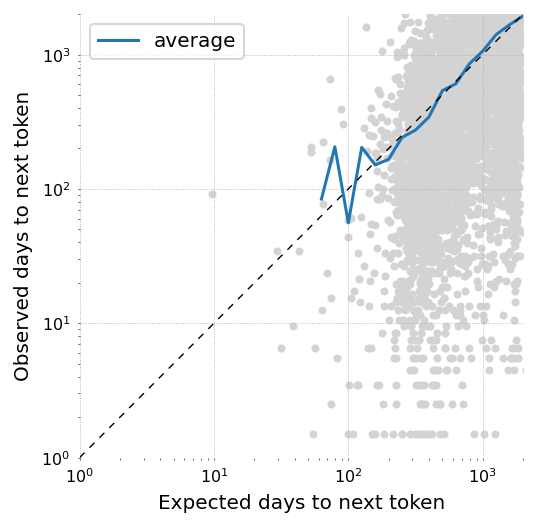

In [10]:
from scipy.special import logsumexp

# Calculate expected waiting times from model predictions using competing exponentials theory
# In Delphi's framework, each possible event has an exponential distribution with rate λᵢ = exp(logits[i])
# The expected time until any event occurs is 1/sum(λᵢ) = 1/exp(logsumexp(logits))
# logsumexp provides numerical stability vs. calculating exp(logits) directly

# Let's see how the predicted waiting times compare to the observed waiting times

plt.figure(figsize=(4, 4))
# Calculate expected time to next token (inverse of hazard rate)
expected_t = 1/np.exp(logsumexp(p, axis=-1))

# Define bin width for logarithmic binning
delta_log_t = 0.1
log_range = np.arange(1.75, 4, delta_log_t)

# Calculate average observed time for each logarithmic bin
observed_t = []
for i in log_range:
    # Create mask for current bin and valid times
    bin_mask = (expected_t > 10**i) & (expected_t <= 10**(i+delta_log_t)) & (t > 0)
    # Calculate mean for this bin
    bin_mean = t[bin_mask].mean() if bin_mask.sum() > 0 else np.nan
    observed_t.append(bin_mean)
plt.axes().set_aspect('equal')
plt.scatter(expected_t, t+0.5, marker=".", c='lightgrey', rasterized=True)
plt.xlabel('Expected days to next token')
plt.ylabel('Observed days to next token')
plt.plot(10**(np.arange(1.75,4,delta_log_t)+delta_log_t/2.),observed_t, label='average')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim(1,2e3)
plt.ylim(1,2e3)
plt.plot([0,1],[0,1], transform = plt.gca().transAxes, c='k' , ls=(0, (5, 5)), linewidth=0.7)

plt.gca().tick_params(length=1.15, width=0.3, labelsize=8, grid_alpha=1, grid_linewidth=0.45, grid_linestyle=':')
plt.gca().tick_params(length=1.15, width=0.3, labelsize=8, grid_alpha=0.0, grid_linewidth=0.35, which='minor')

## Incidence

In [11]:
## Load large chunk of data 
# `get_batch` function reads health trajectories from the dataset for requested indices of individuals
# it also packes the trajectories into batches of size `block_size`, padding with padding token if needed
# finally, it randomly add no event tokens and returns a tuple of tensors:
# - `d[0]`: diseases
# - `d[1]`: corresponding age
# - `d[2]`: disease labels (same as `d[0]`, but shifted by 1)
# - `d[3]`: label age (same as `d[1]`, but shifted by 1)
subset_size = 10_000
d = get_batch(range(subset_size), val, val_p2i,  
              select='left', block_size=128, 
              device=device, padding='random')

In [12]:
# 2 is female token, 3 is male token

is_male = (d[0] == 3).any(axis=1).cpu().numpy()
is_female = (d[0] == 2).any(axis=1).cpu().numpy()
has_gender = is_male | is_female

In [13]:
# lets split the large data chanks to smaller batches and calculate the logits for the whole dataset
p = []
model.to(device)
batch_size = 256
subset_size = min(dataset_subset_size, 10_000)
with torch.no_grad():
    for d_batch in tqdm(zip(*map(lambda x: torch.split(x, batch_size), d)), total=d[0].shape[0]//batch_size+1):
        p.append(model(*d_batch)[0].cpu().detach())
p = torch.vstack(p)

d = [d_.cpu() for d_ in d]

100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.00it/s]


###  Age-sex incidence baseline

In [14]:
# calculate disease incidence rates for each disease, given age and sex

females = train[np.isin(train[:,0], train[train[:,2]==1,0])]
males = train[np.isin(train[:,0], train[train[:,2]==2,0])]
n_females = (train[:,2]==1).sum()
n_males = (train[:,2]==2).sum()

unique_male_indices = np.where(males[:-1,0] != males[1:,0])[0]
unique_female_indices = np.where(females[:-1,0] != females[1:,0])[0]

def calc_age_distribution(data, unique_indices):
    ages = np.maximum(40, np.round(data[unique_indices, 1]/365.25) + 1)
    counts = np.histogram(ages, np.arange(100))[0]
    cumulative = -np.cumsum(counts)
    return cumulative - cumulative[-1]

n_males = calc_age_distribution(males, unique_male_indices)
n_females = calc_age_distribution(females, unique_female_indices)

ukb_condition = (males[:,2] > 2) & (males[:,2] <= 4)
males_in_ukb = np.cumsum(np.histogram((males[ukb_condition, 1]/365.25).astype('int'), np.arange(100))[0])

ukb_condition = (females[:,2] > 2) & (females[:,2] <= 4)
females_in_ukb = np.cumsum(np.histogram((females[ukb_condition, 1]/365.25).astype('int'), np.arange(100))[0])

### Modelled age-incidence

### Selected diseases

Delphi predicts the disease rate. Let's plot Delphi-predicted rates for the selected diseases vs age and compare them with the reported incidence rates (population averages from UKB).

Shown in the graph are population average disease rates (solid lines), Delphi-predicted rates for arbitrary timepoints (pale dots) and Delphi-predicted rates for the penultimate step before disease (bright dots).

Bright dots are often located above the population average rates, which indicates that Delphi correctly captures the elevated disease risk for such participants.

In [15]:
def plot_age_incidence(ix, d, p, highlight_idx=0):
    """
    Plot age-specific incidence rates for selected diseases.
    
    Parameters:
    -----------
    ix : list or array
        Indices of diseases to plot
    d : tuple
        Tuple containing disease data:
        - d[0]: disease history
        - d[1]: age information
        - d[2]: disease labels
        - d[3]: additional time information
    p : torch.Tensor
        Probability tensor from Delphi model
    highlight_idx : int, default=0
        Index of the case to highlight in the trajectory plot
    
    Returns:
    --------
    None
        Displays the plot but doesn't return any value
    """
    # Calculate number of rows needed based on number of diseases
    n_rows = (len(ix) - 1) // 5 + 1
    fig, ax = plt.subplots(n_rows, 5, figsize=(18, 3 * n_rows), sharex=False, sharey=True)
    axf = ax.ravel()
    
    for i, k in enumerate(ix):
        # Prepare data
        x = d[1][:,:].detach().numpy() / 365.25
        y = np.exp(p.detach().numpy()[:,:,k]) * 365.25
        y = 1 - np.exp(-y)
        
        # Filter for cases without prior disease
        no_prior_disease = ~np.isin(d[0], k).any(axis=1)
        sub_sample = np.random.randint(0, len(x[has_gender * no_prior_disease].ravel()), 5000)
        
        # Plot background points
        axf[i].scatter(
            x[has_gender * no_prior_disease].ravel()[sub_sample], 
            y[has_gender * no_prior_disease].ravel()[sub_sample], 
            marker='.', 
            c=np.repeat(np.array([light_female, light_male])[0+is_male[has_gender * no_prior_disease]], x.shape[1]).ravel()[sub_sample],
            edgecolors='white', 
            s=50, 
            label='Delphi, all time steps', 
            rasterized=True
        )
        
        # Plot points just before disease onset
        has_k = np.where(d[2].detach().numpy()[has_gender] == k)[0]
        before_k = d[2].detach().numpy()[has_gender].ravel() == k
        axf[i].scatter(
            x[has_gender].ravel()[before_k], 
            y[has_gender].ravel()[before_k], 
            marker='.', 
            c=np.array([dark_female, dark_male])[0+is_male[has_gender][has_k]],
            edgecolors='white', 
            s=50, 
            label='Delphi, penultimate step before disease', 
            rasterized=True
        )

        # Plot selected case trajectory
        j = np.where(np.isin(d[2], k).any(axis=1))[0][highlight_idx]
        j0 = np.where(x[j] >= 0)[0][0]
        jk = np.where(d[2][j,:].detach().numpy() == k)[0][0]
        axf[i].plot(
            x[j][j0:jk+1], 
            y[j][j0:jk+1], 
            ds='steps-post', 
            c='k', 
            ls="-", 
            marker='.', 
            markersize=8, 
            markeredgecolor='white', 
            markerfacecolor='k', 
            label='selected case'
        )
        axf[i].scatter(x[j][jk], y[j][jk], marker='.', s=200, edgecolors='white', c='k', zorder=3)

        # Plot reported incidence rates
        h, x = np.histogram(females[females[:,2]==k-1,1]/365.25, np.arange(100))
        axf[i].stairs(h/n_females, x, color=normal_female, lw=2, label='reported incidence, female')
        
        h, x = np.histogram(males[males[:,2]==k-1,1]/365.25, np.arange(100))
        axf[i].stairs(h/n_males, x, color=normal_male, lw=2, label='reported incidence, male')
        
        # Set plot properties
        axf[i].set_ylim((1e-5, 1))
        axf[i].set_xlim((0, 80))
        axf[i].set_yscale('log')
        axf[i].set_title("\n".join(textwrap.wrap(delphi_labels.loc[k,'name'], width=30)), 
                         verticalalignment='top', fontsize=10, fontweight='bold')
        
        if i % ax.shape[1] == 0:
            axf[i].set_ylabel('Rate per year')

        if i // ax.shape[1] == ax.shape[0] - 1:
            axf[i].set_xlabel('Age')
        
        if i == len(ix) - 1:
            axf[i].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

/ssd/a193o/39192841/cluster_tmp/ipykernel_2369468/3864922566.py:86: RuntimeWarning: invalid value encountered in divide
  axf[i].stairs(h/n_females, x, color=normal_female, lw=2, label='reported incidence, female')
/ssd/a193o/39192841/cluster_tmp/ipykernel_2369468/3864922566.py:89: RuntimeWarning: invalid value encountered in divide
  axf[i].stairs(h/n_males, x, color=normal_male, lw=2, label='reported incidence, male')


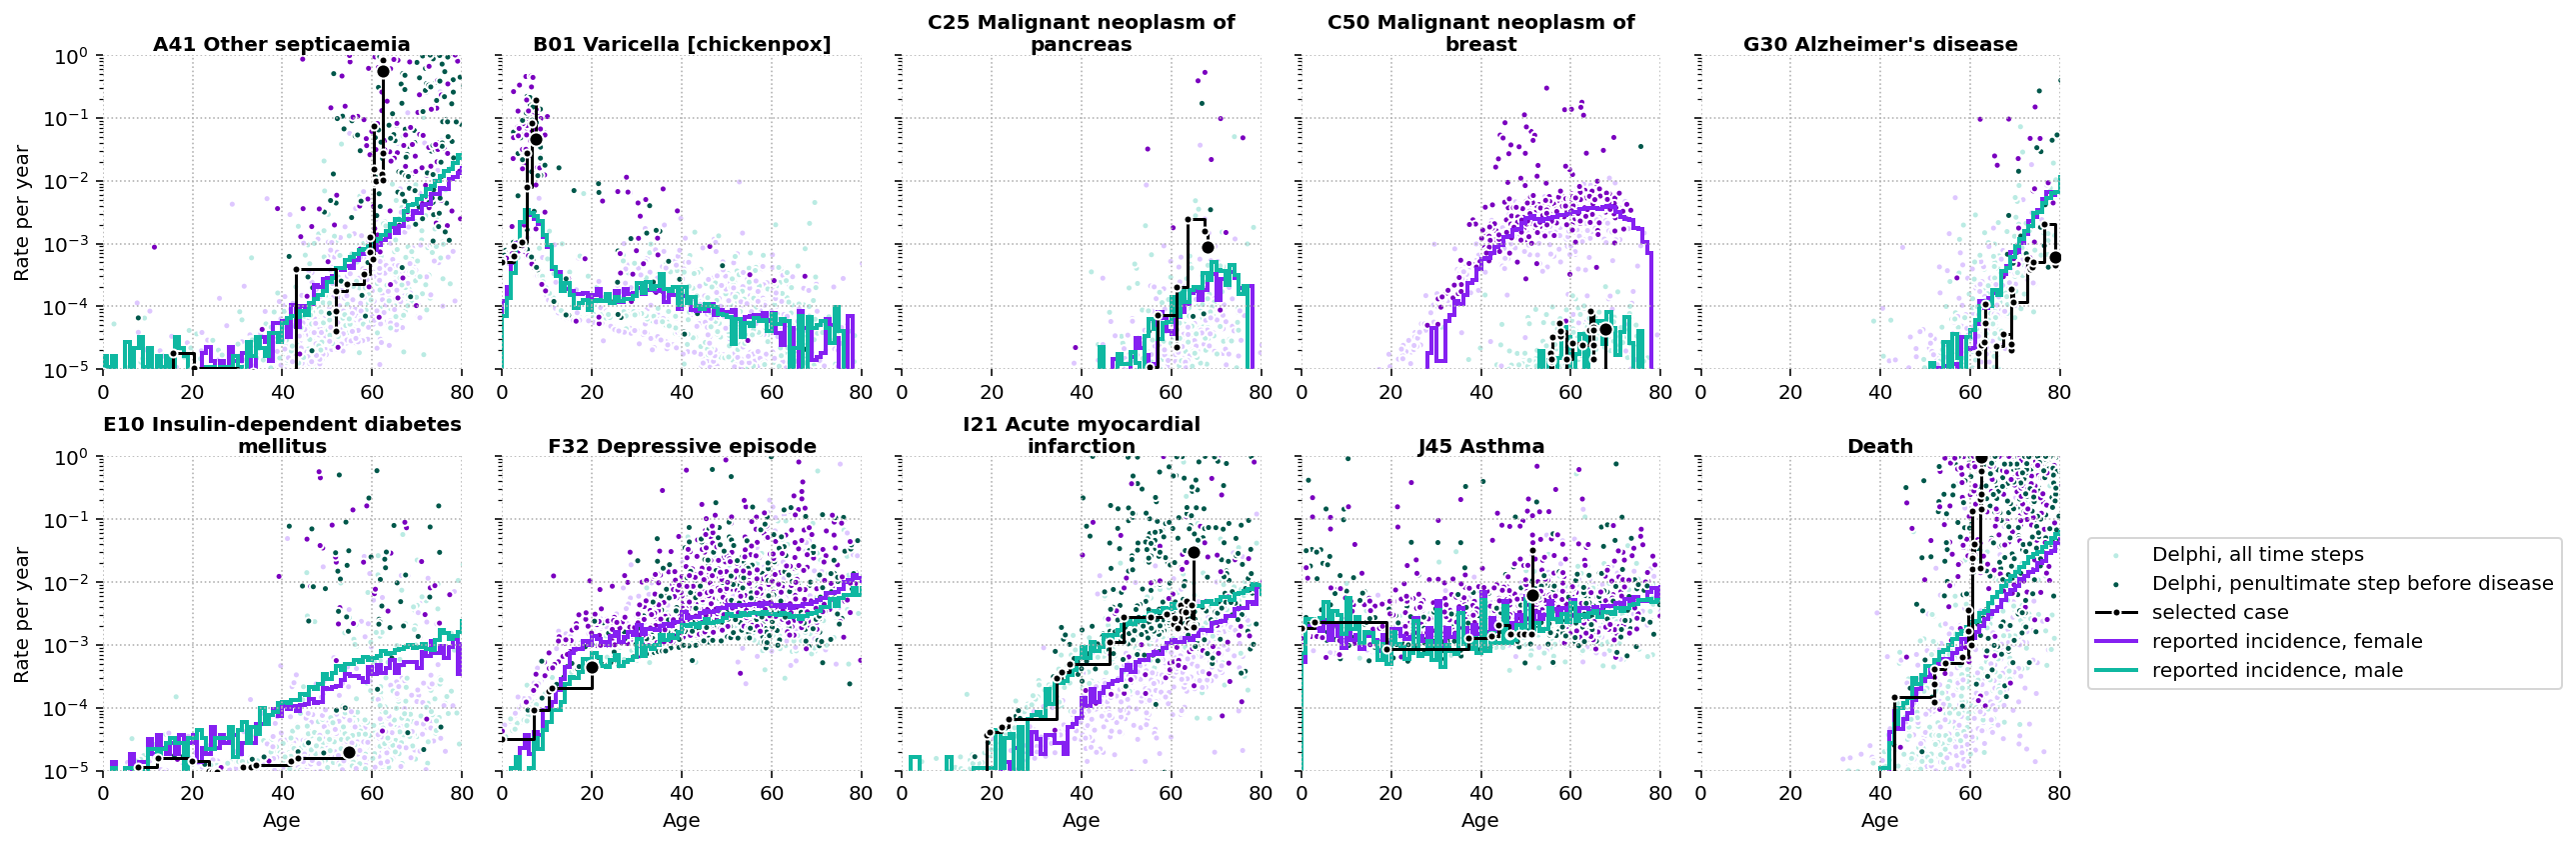

In [16]:
plot_age_incidence(diseases_of_interest, d, p, highlight_idx=0)
plt.gcf().tight_layout(h_pad=0.5)
plt.show()

### Calibration
Delphi predicts the absolude disease rate. In this section, we evaluate how well Delphi's predictions match the observed disease rates in the UKB dataset.

The strategy for calibration assesment is the following:
1. Run Delphi for the entire dataset
2. Stratify all participants into sex & age groups
3. For each age-sex group, split all participants into bins according to the predicted disease risk
4. For each bin, calculate the observed and predicted disease rates
5. Plot the calibration curve


In [17]:
def auc(x1, x2):
    "Calcualte AUC, given x1 vector of disease risks for cases and x2 vector of disease risks for controls"
    n1 = len(x1)
    n2 = len(x2)
    R1 = np.concatenate([x1,x2]).argsort().argsort()[:n1].sum() + n1
    U1 = n1*n2 + 0.5*n1*(n1+1) - R1
    if n1 == 0 or n2 == 0:
        return np.nan
    return U1 / n1 / n2

In [18]:
d100k = get_batch(range(dataset_subset_size), val, val_p2i,  
              select='left', block_size=128, 
              device=device, padding='random')

In [19]:
p100k = []
model.to(device)
batch_size=256
with torch.no_grad():
    for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), d100k)), total=d100k[0].shape[0]//batch_size+1):
        p100k.append(model(*[x.to(device) for x in dd])[0].cpu().detach()[:,:,diseases_of_interest].numpy())
p100k = np.vstack(p100k)

  0%|                                                                               | 0/394 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████| 394/394 [01:18<00:00,  5.05it/s]


In [20]:
import scipy
import warnings

def plot_calibration(disease_idx, data, logits, offset = 365.25, age_groups=range(45,85,5), n_samples=3, calibration = 'bins', binning='power', bins=10**np.arange(-6.,1.5,.5)):
    """
    Plot calibration curves for disease predictions.
    The selection of controls and cases in this function happens in the following way:
    - For cases, we can just select the predicted disease rates corresponding to the moment before 
      occurrence of the disease (given the offset).
    - For controls, there isn't a particular moment in time when the disease occurs, so we just 
      sample random moments of the trajectory.
    
    Args:
        disease_idx: Index of disease in the dataset
        data: Tuple of tensors containing input data (tokens, times, targets, target_times)
        logits: Model prediction logits
        offset: Time offset in days (default: 365.25)
        age_groups: Range of age groups to analyze (default: range(45,85,5))
        n_samples: Number of samples (default: 3)
        calibration: Calibration method, 'bins' or other (default: 'bins')
        binning: Binning method, 'power' or 'deciles' (default: 'power')
        bins: Bin edges for power binning (default: 10**np.arange(-6.,1.5,.5))
        
    Returns:
        List of calibration data for each age group
    """
    
    l = len(age_groups)
    age_step = age_groups[1] - age_groups[0]

    fig, ax = plt.subplots(2, l, figsize=(20/8*l,3), sharex=True, sharey=False, height_ratios=[1, .5])
    # Indices of cases
    wk = np.where(data[2].detach().numpy()==disease_idx) 
    
    if len(wk[0])<2:
        return np.repeat(np.nan, l)
  
    # Indices of controls
    wc = np.where(data[2].detach().numpy()!=disease_idx) 
    
    c_sub = range(wc[0].shape[0])
    wall = (np.concatenate([wk[0], wc[0][c_sub]]), np.concatenate([wk[1], wc[1][c_sub]])) 
        
    pred_idx = (data[1][wall[0]] <= data[3][wall].reshape(-1,1) - offset).sum(1) -1
    z = data[1].detach().numpy()[(wall[0], pred_idx)]
    z = z[pred_idx != -1]

    zk = data[3].detach().numpy()[wall] # Target ages, cases and controls
    zk = zk[pred_idx != -1] 
    
    x = np.exp(logits[(wall[0], pred_idx)]) * 365.25 # Disease rates
    x = x[pred_idx != -1]
    x = 1 - np.exp(-x * age_step)
    
    wk = (wk[0][pred_idx[:len(wk[0])] != -1], wk[1][pred_idx[:len(wk[0])] != -1])
    p_idx = wall[0][pred_idx!=-1]
    
    out = []
        
    for i,aa in enumerate(age_groups):
        ax_cal = ax[0, i] # Calibration plot
        ax_box = ax[1, i] # Boxplot

        a = np.logical_and(z / 365.25 >= aa, z / 365.25 < aa+ age_step)
        a *= zk - z < 365.25 #* age_step
        a *= np.isin(np.arange(a.shape[0]),np.unique(p_idx * a, return_index=True)[1]) # Mask duplicated people in age bracket
        ax_box.boxplot((x[len(wk[0]):][a[len(wk[0]):]], x[:len(wk[0])][a[:len(wk[0])]]), vert=False, sym='.', widths=.5, whis=(5,95), 
                        flierprops=dict(marker='.', markeredgecolor='white', markerfacecolor='k'))
        ax_box.set_xscale('log')
        ax_box.set_xlim((1e-5, 1))
        ax_box.set_yticks((1,2), ['',''])
        if i==0:
            ax_cal.set_ylabel('Observed rate [1/yr]')
            ax_box.set_yticks((1,2), (f'{["Healthy","Alive"][disease_idx==1268]}',f'{["Diseased","Deceased"][disease_idx==1268]}'))
        y = auc(x[len(wk[0]):][a[len(wk[0]):]], x[:len(wk[0])][a[:len(wk[0])]])
        
        foo =["dis'd","dec'd"]
        ax_cal.text(0,.9, s= f'{len(x[len(wk[0]):][a[len(wk[0]):]])} {["healthy","alive"][disease_idx==1268]}\n{len(x[:len(wk[0])][a[:len(wk[0])]])} {foo[disease_idx==1268]}', 
                    transform=ax_cal.transAxes, va='top')
        ax_box.text(0.5, .8, s = f"AUC={y:.2}",  transform=ax_box.transAxes,  va='center', ha='center')
        ax_box.set_xlabel('Predicted rate [1/yr]')
        ax_box.set_ylim((0.5,3.5))
        ax_cal.text(0.5, 1, s = f'{aa}-{aa+age_step}yr', transform=ax_cal.transAxes, va='bottom', ha='center', weight='bold')

        
        xa = x[a]
        ya = np.concatenate([np.ones(len(wk[0])), np.zeros(x.shape[0] - len(wk[0]))])[a]
        
        if len(xa) == 0:
            continue
        

        if calibration == 'bins':
            if binning == 'deciles':
                bins = np.quantile(xa, np.arange(0,1.05,0.05))
            else:
                bins = bins
            bin_masks = [np.logical_and(xa > bins[b-1], xa <= bins[b]) for b in range(1,len(bins))]
            # np.errstate doesn't suppress RuntimeWarning, need to use warnings module
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                pred = np.array([xa[bin_mask].mean() for bin_mask in bin_masks])
                obs = np.array([ya[bin_mask].mean() for bin_mask in bin_masks])
            ci = np.array([scipy.stats.beta(0.1 + ya[bin_mask].sum(), 0.1 + (1-ya[bin_mask]).sum()).ppf([0.025,0.975]) for bin_mask in bin_masks])
            ax_cal.scatter(pred, obs + 1e-5, marker='.', c='k')
            for j,pr in enumerate(pred):
                if not np.isnan(obs[j]):
                    ax_cal.plot( np.repeat(pr,2),ci[j], c='k', lw=.5, ls=":")
            wgt = np.array([[ya[bin_mask].sum(),bin_mask.sum()]  for bin_mask in bin_masks])
            out.append([pred, obs, ci, wgt])
        else:
            o = np.argsort(xa)
            ax_cal.plot(xa[o], ya[o]/(ya.sum() - np.cumsum(ya[o]))/age_step, ds='steps')
            out.append(np.nan)
        
        ax_cal.set_box_aspect(1)
        ax_cal.scatter(xa.mean(), ya.mean(), c='r', ec='w')
        ax_cal.set_yscale('log')
        ax_cal.set_xscale('log')
        ax_cal.set_ylim((1e-5, 1))
        ax_cal.set_xlim((1e-5, 1))
        ax_cal.plot([0, 1], [0, 1], transform=ax_cal.transAxes, lw=.5, c='k', ls="--")

    return out    

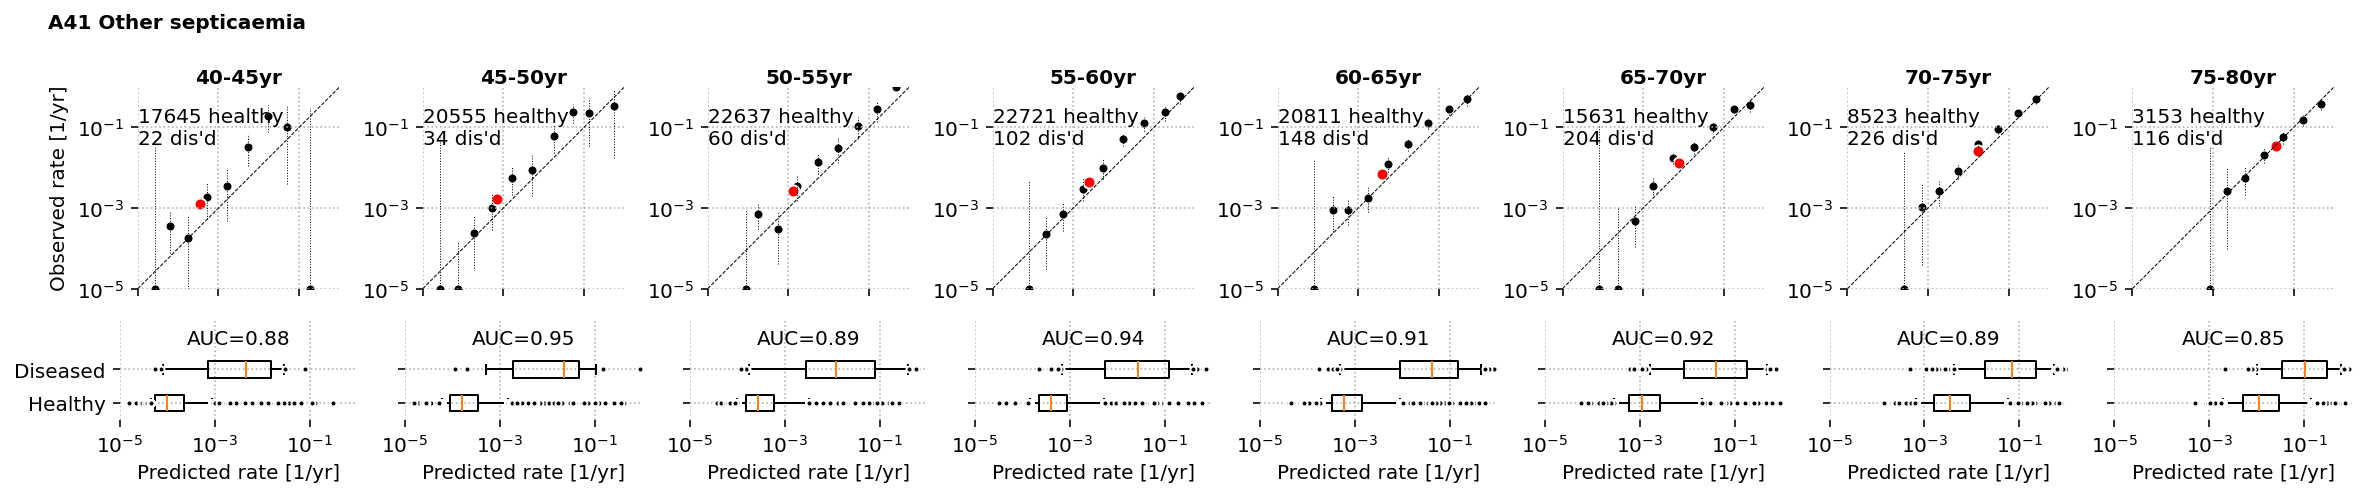

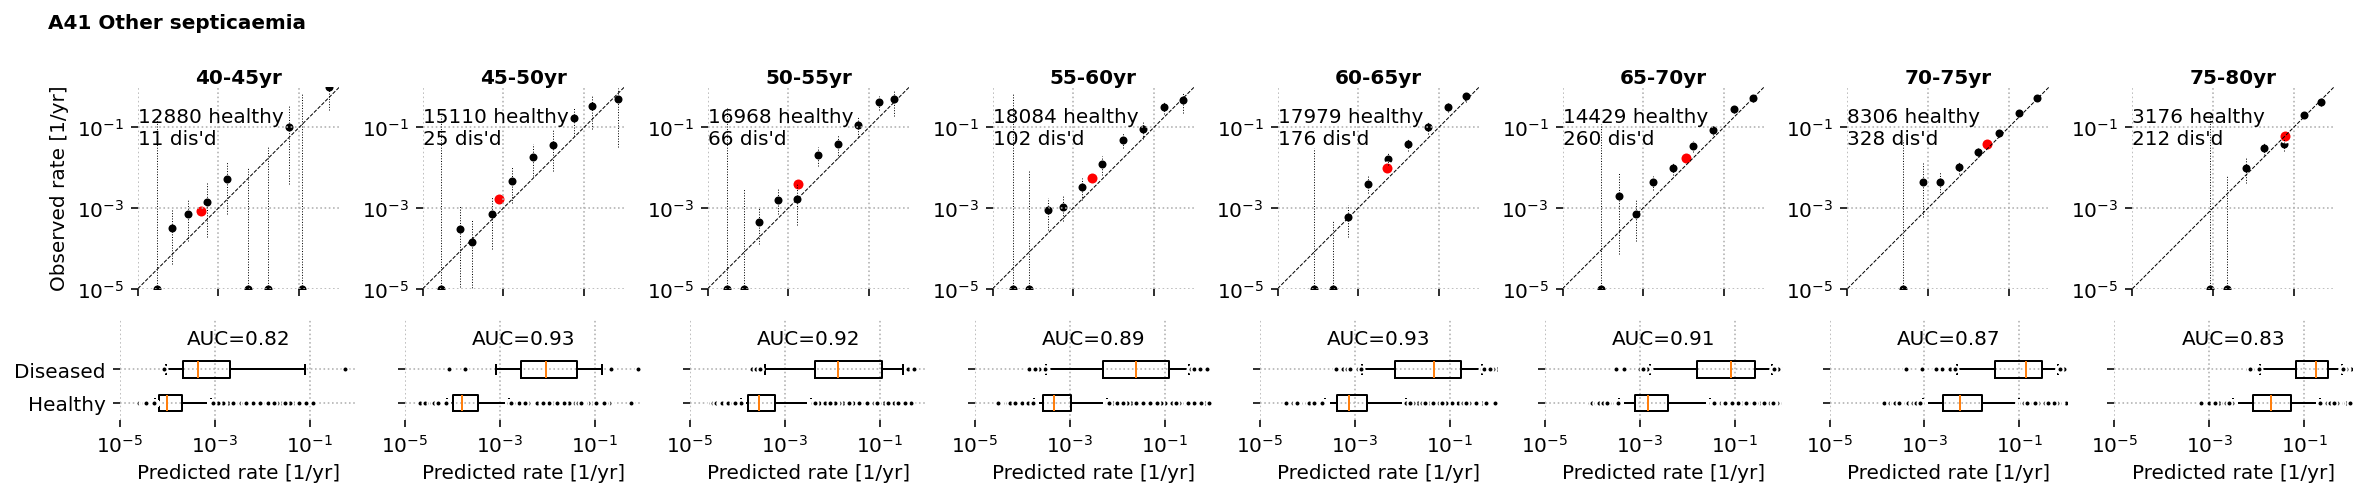

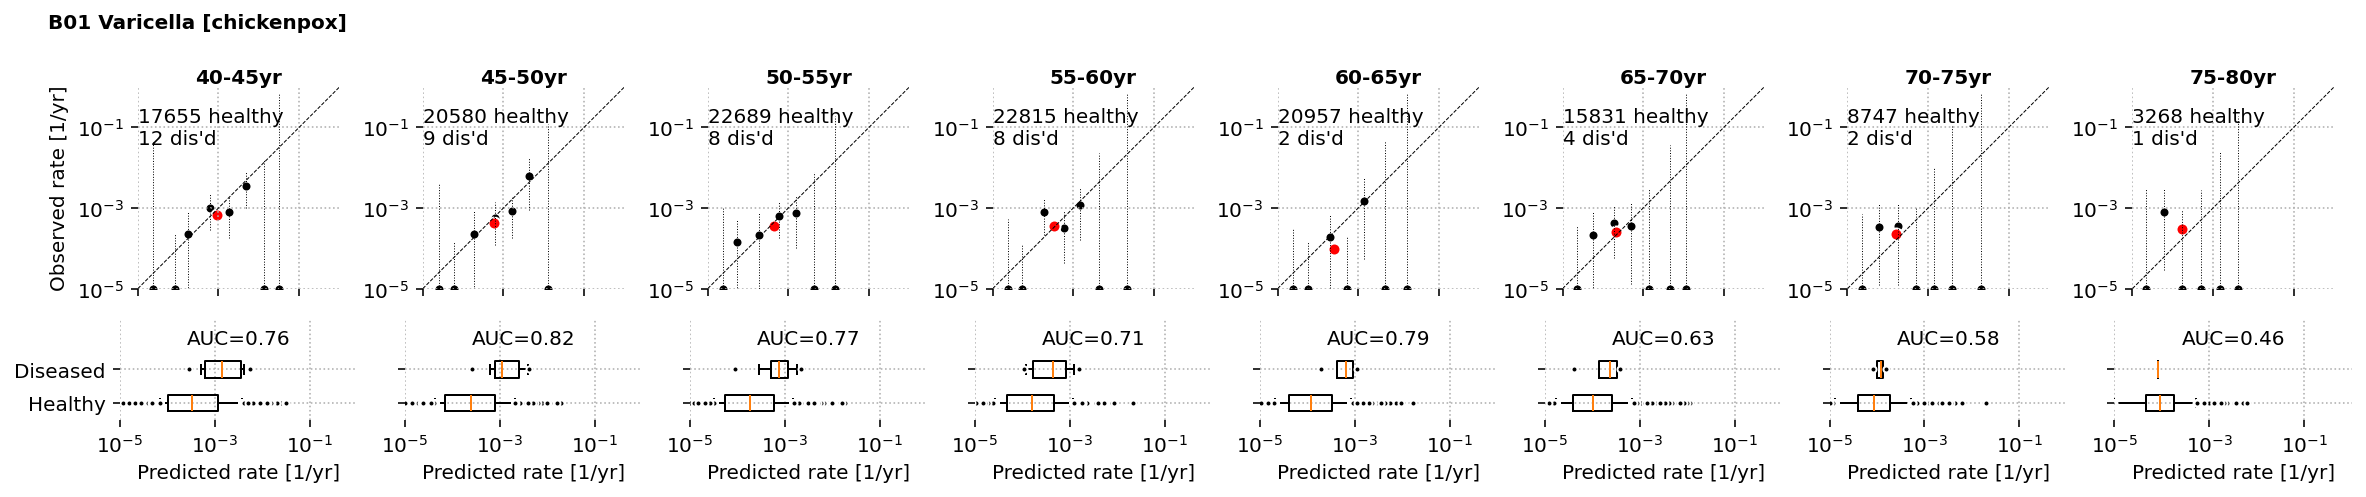

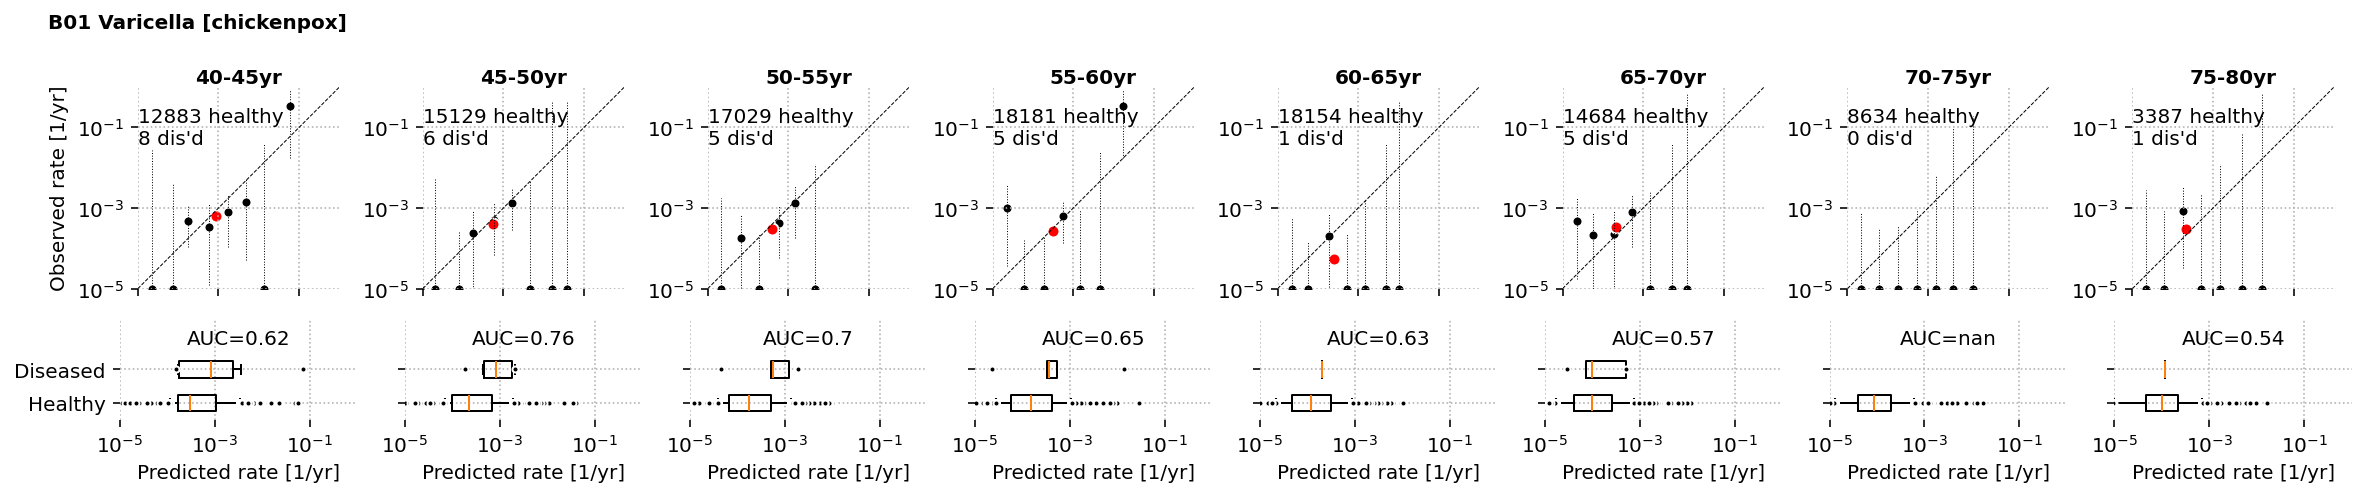

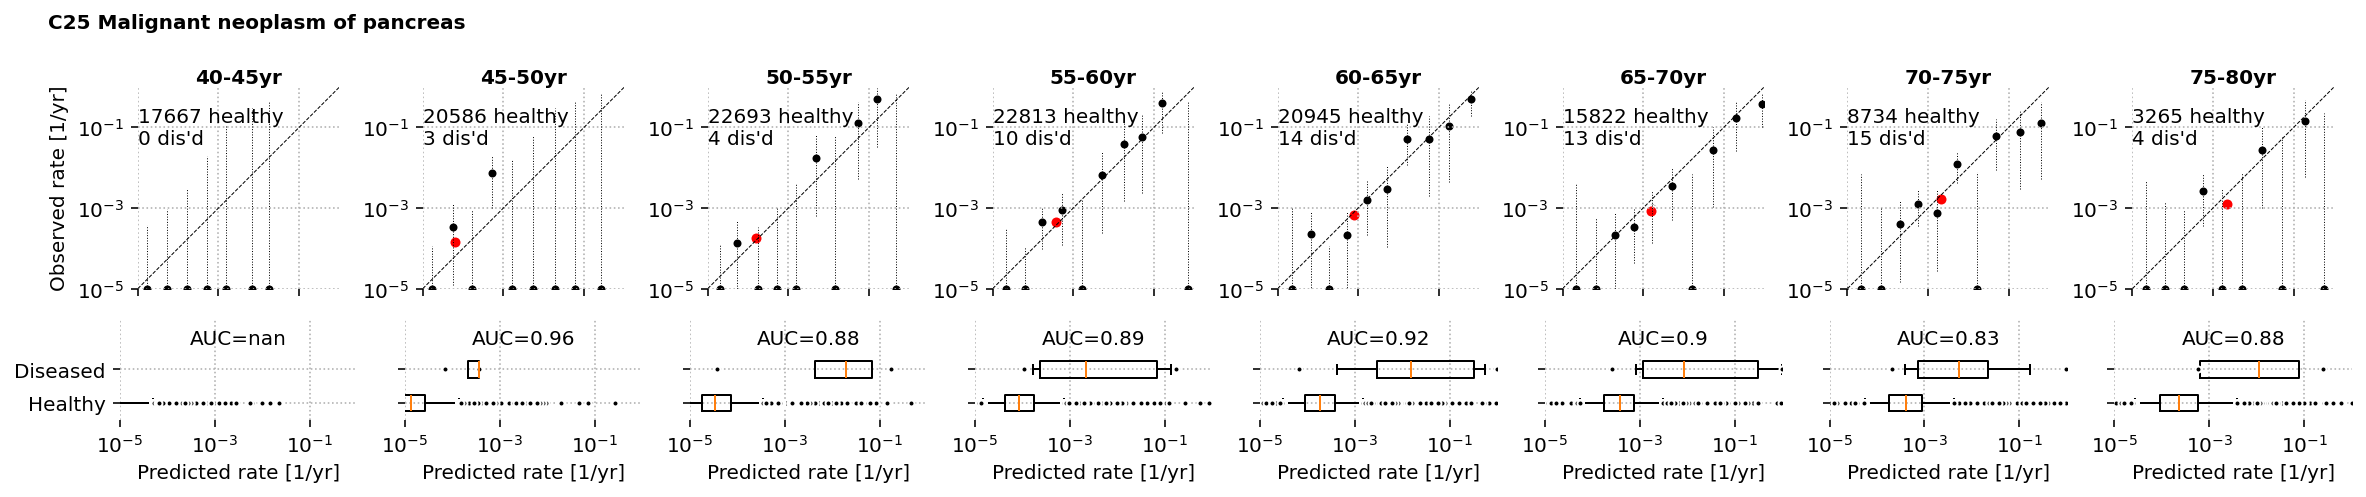

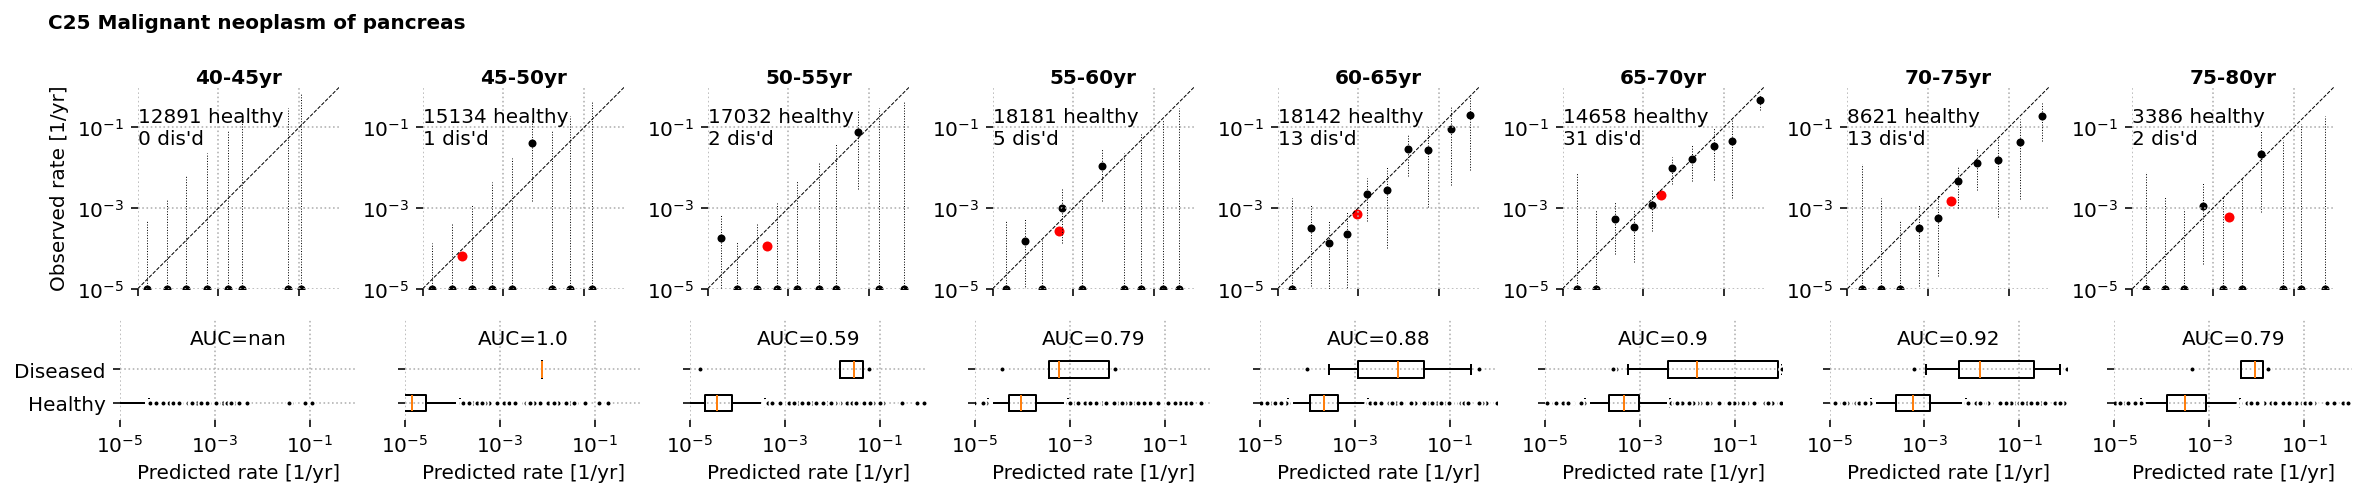

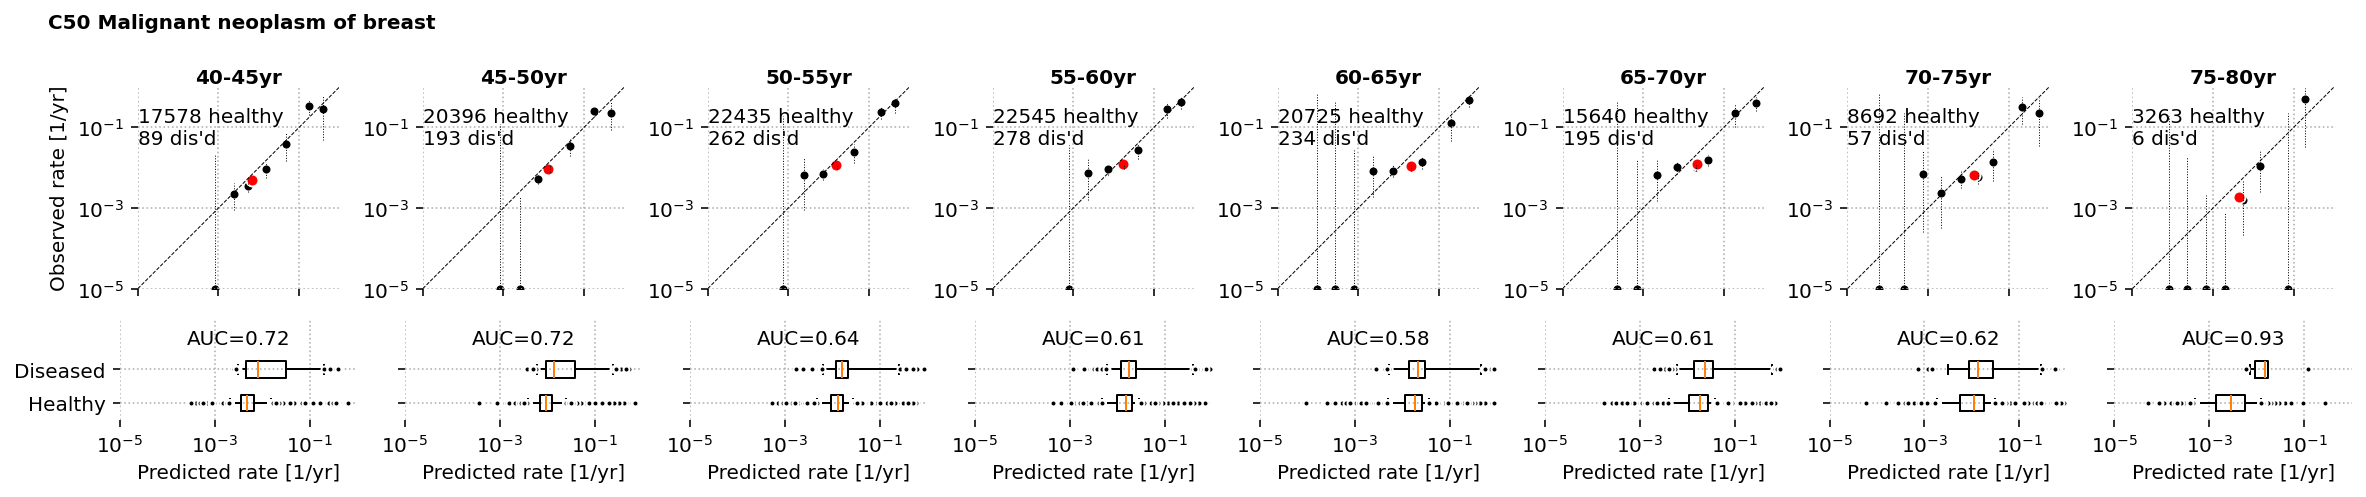

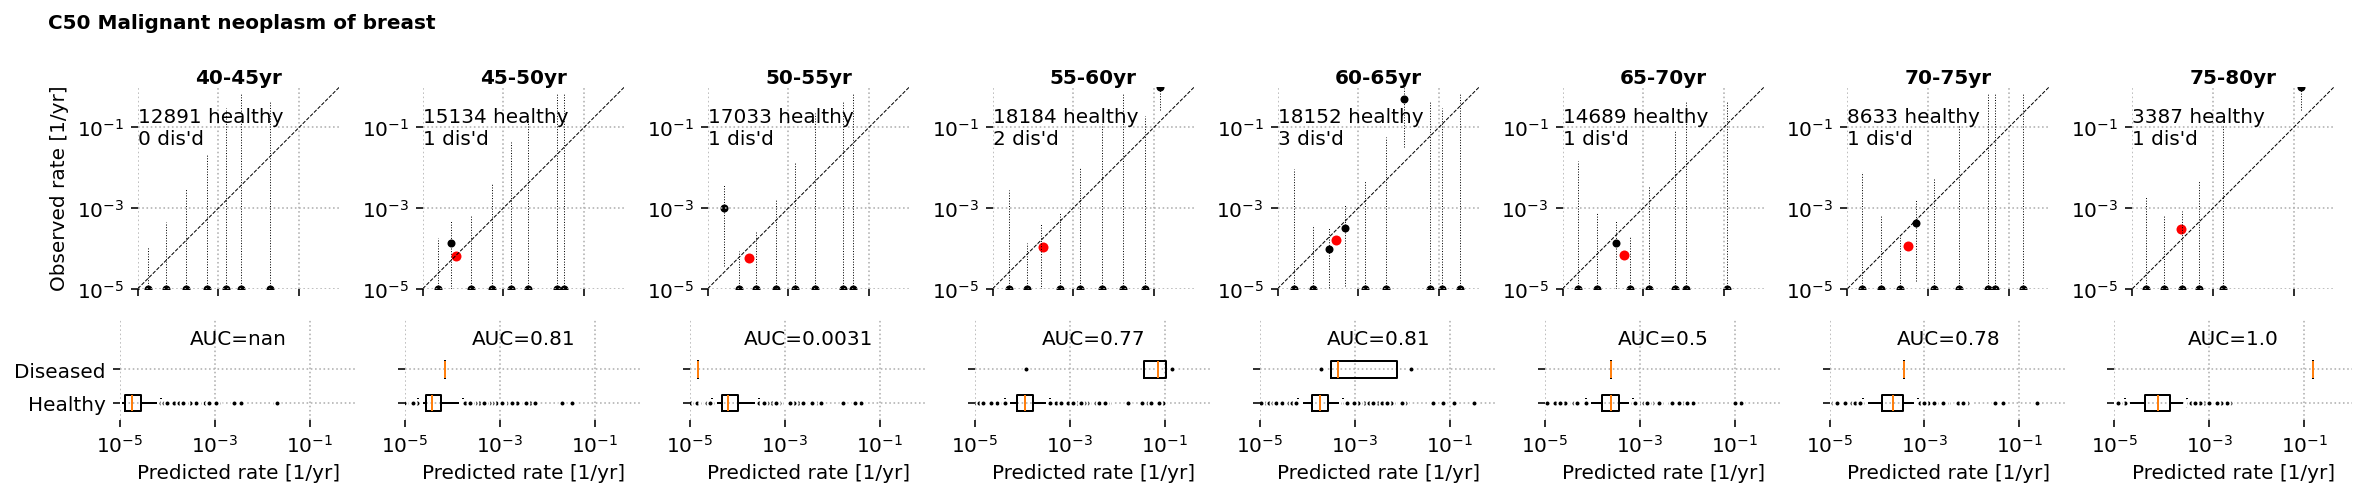

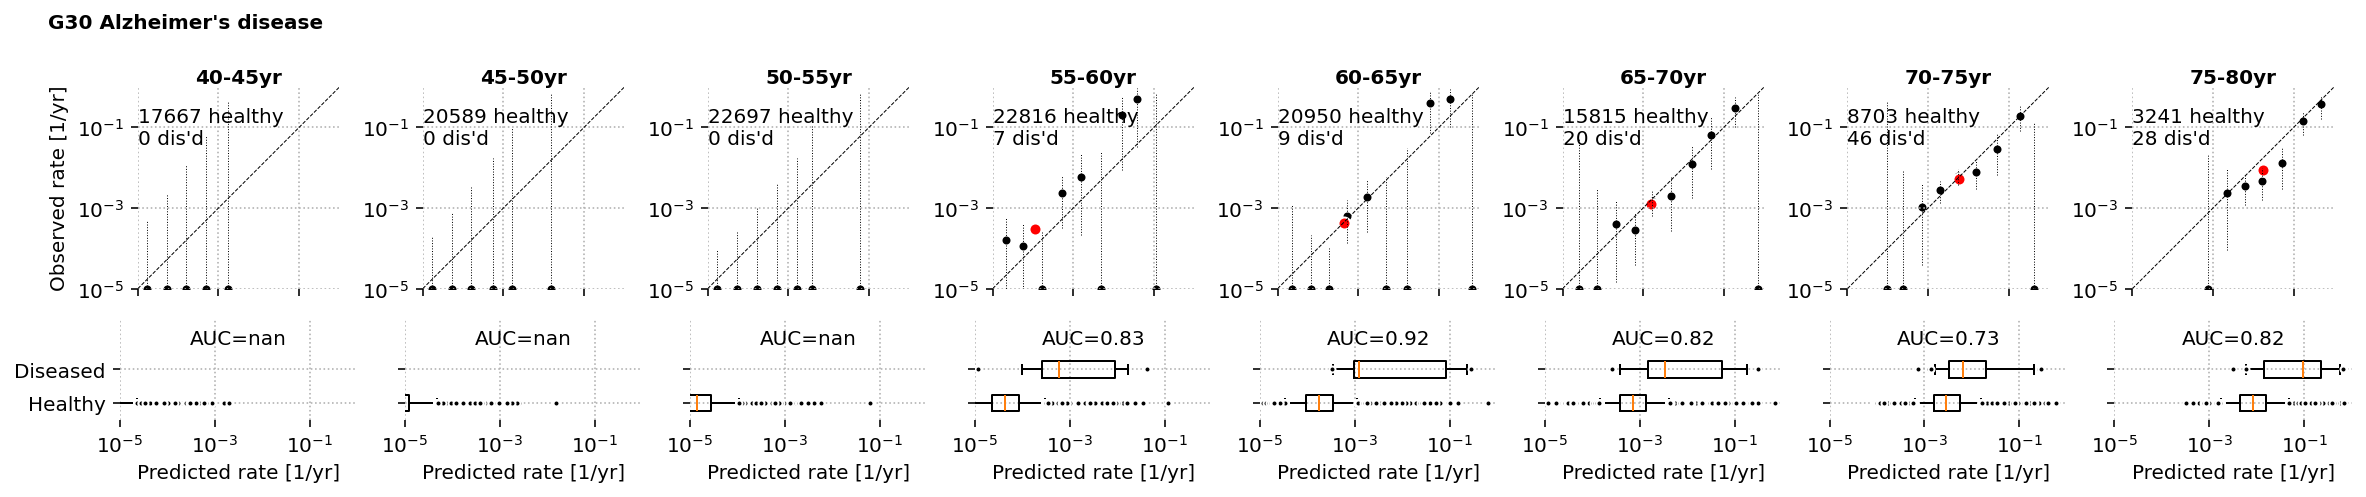

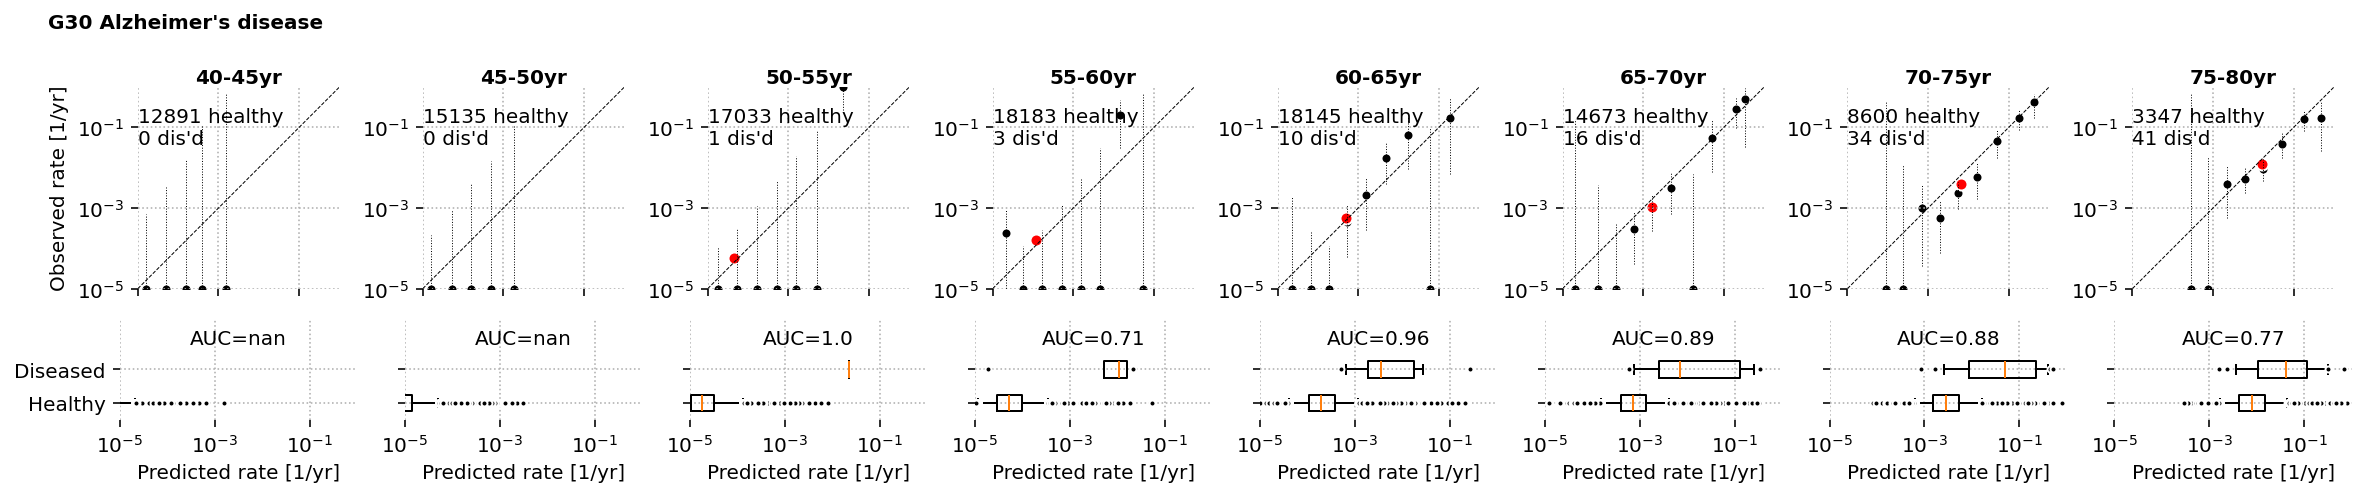

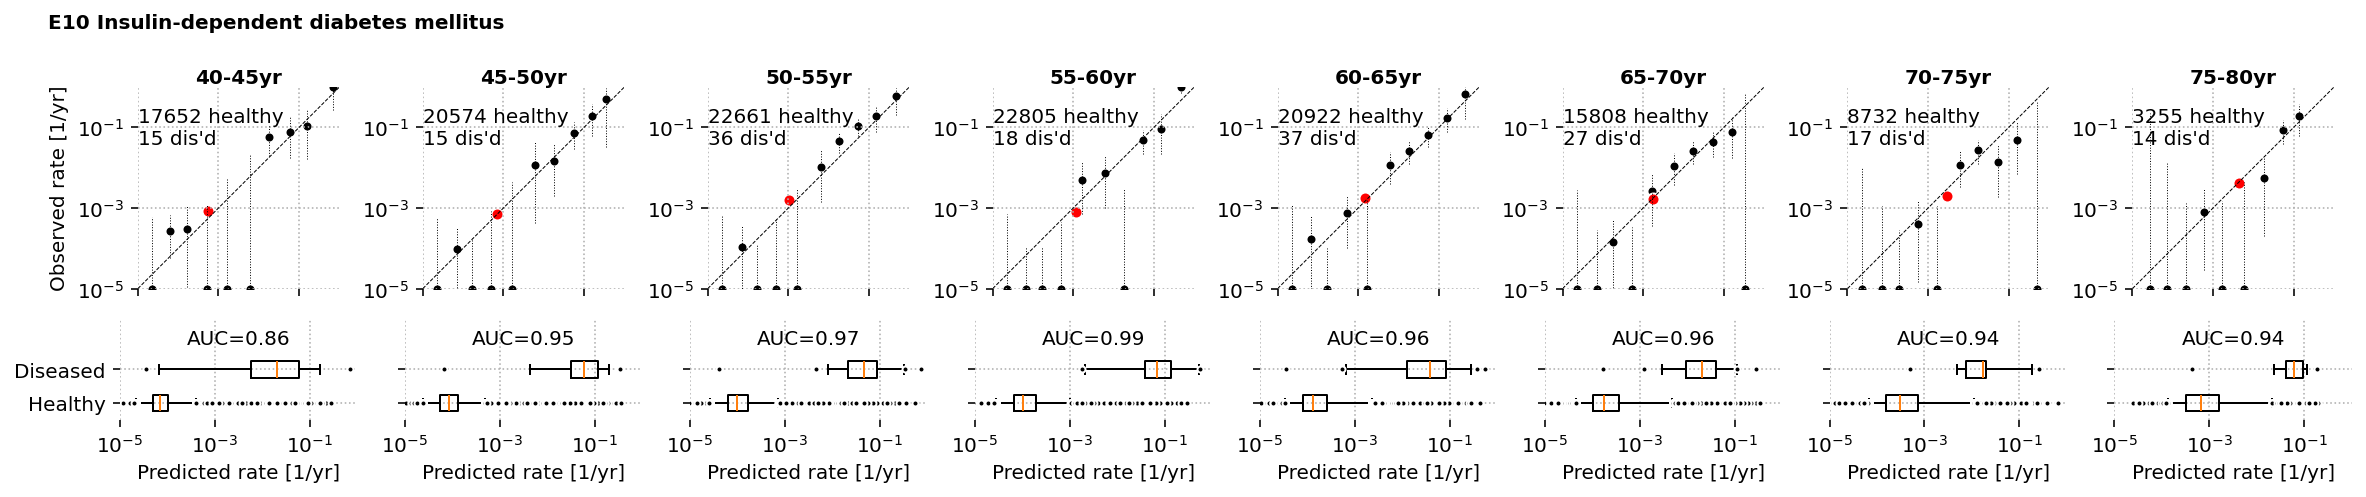

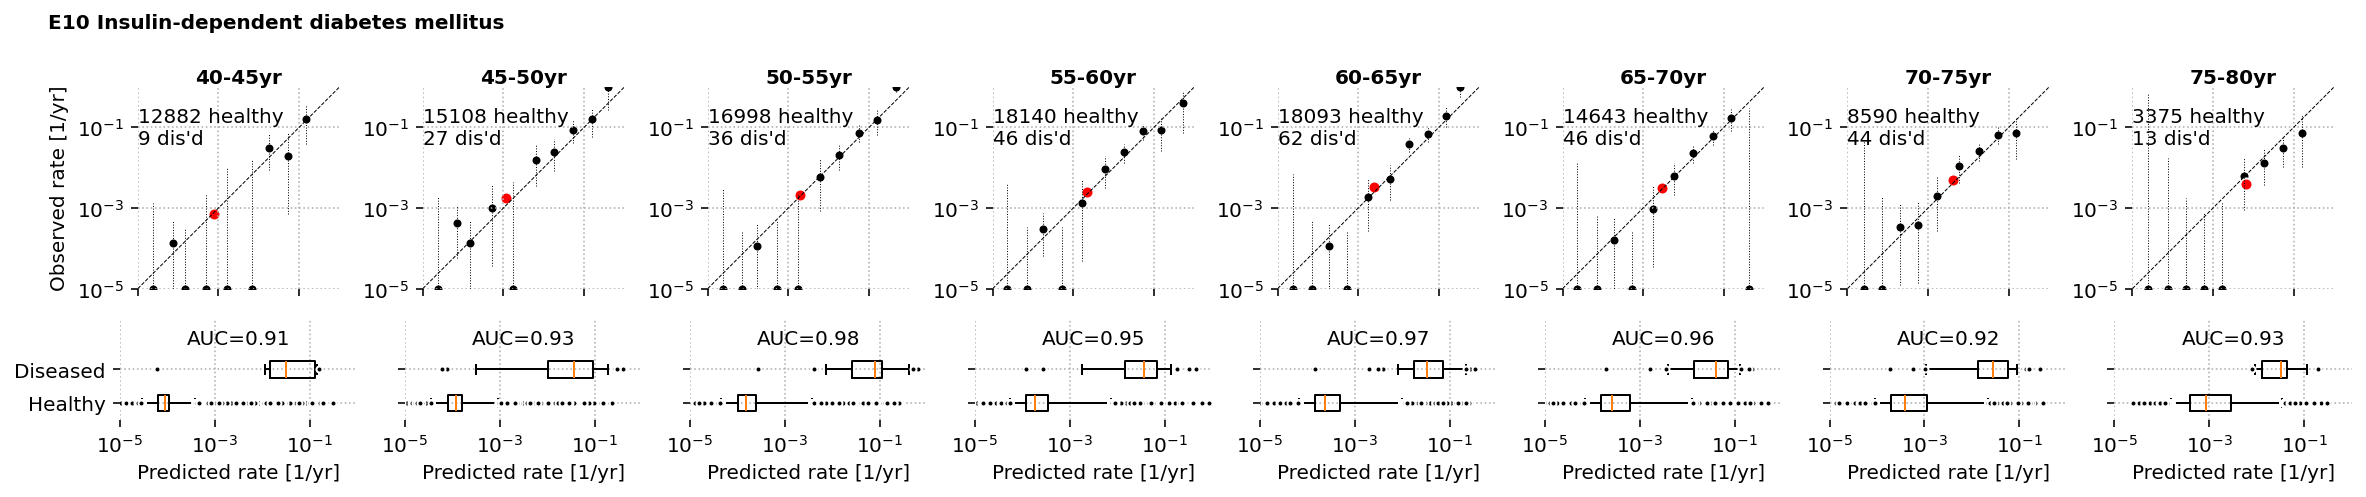

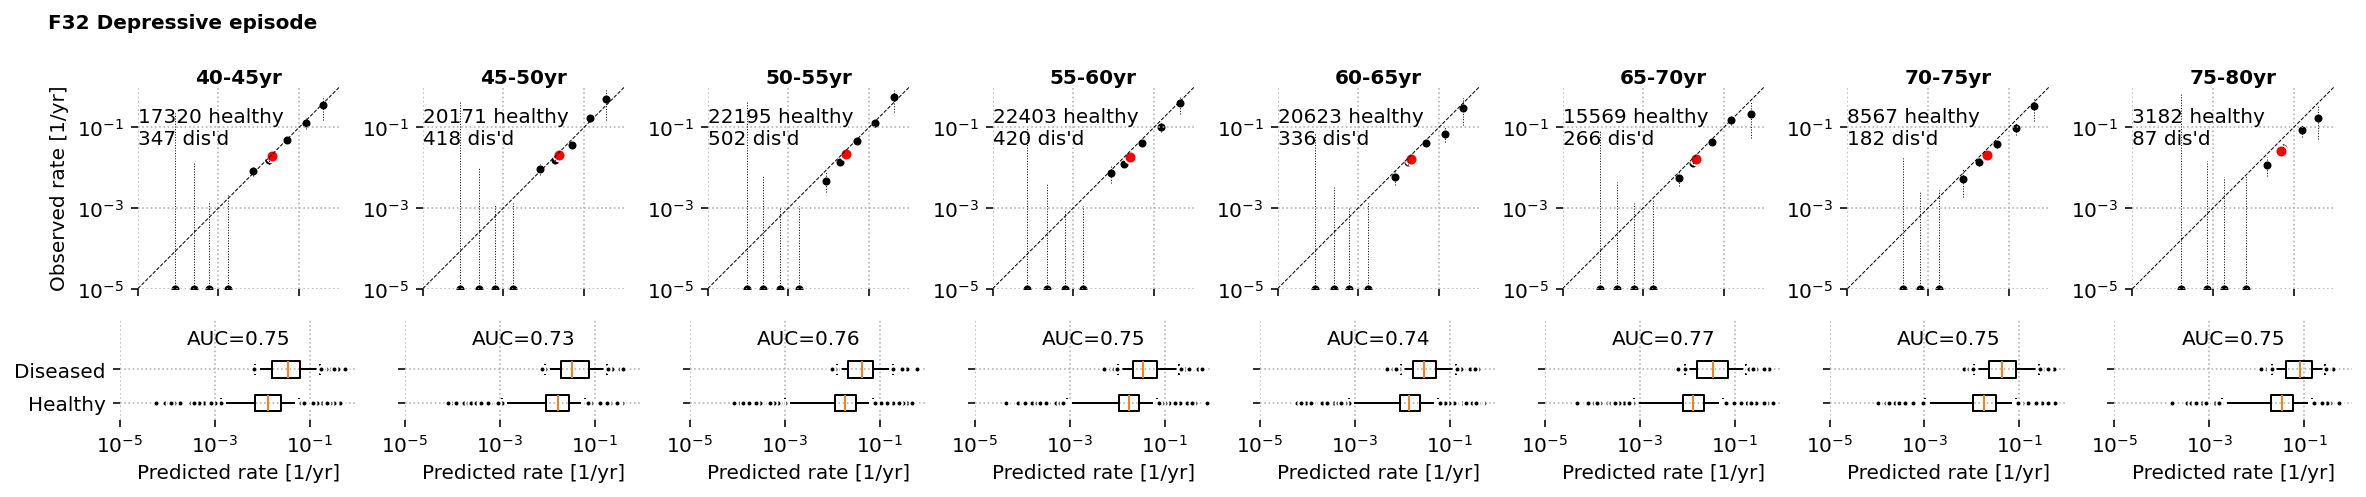

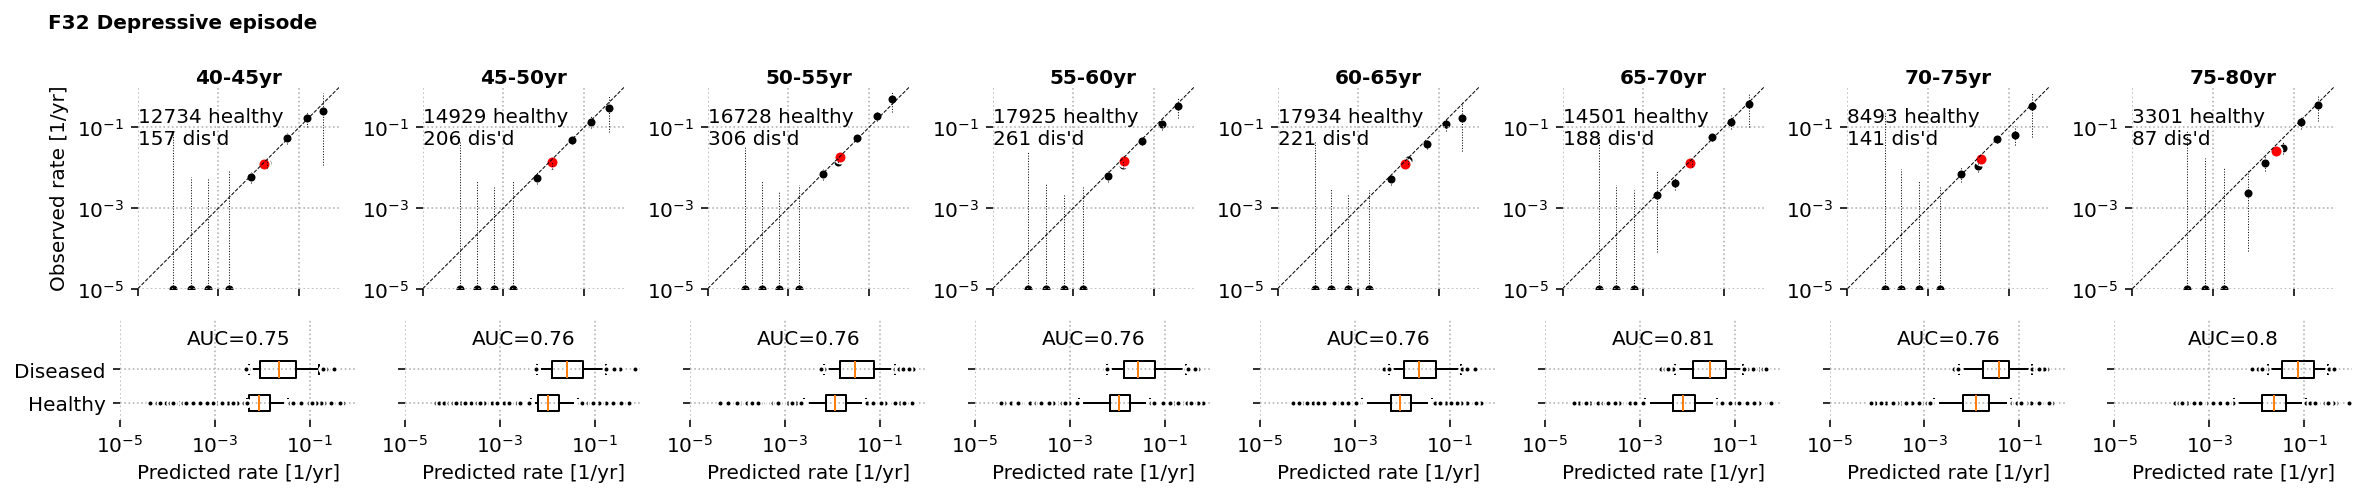

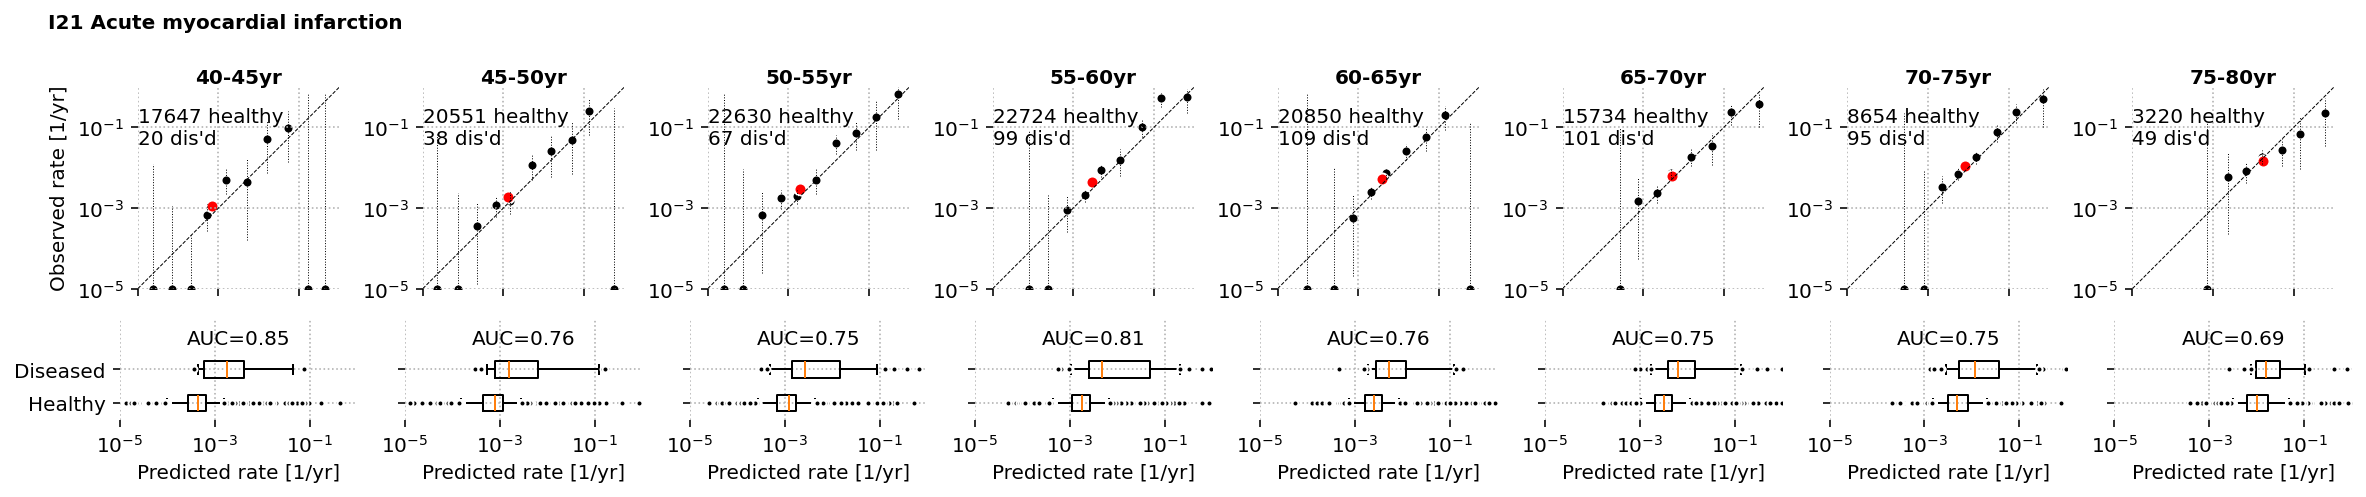

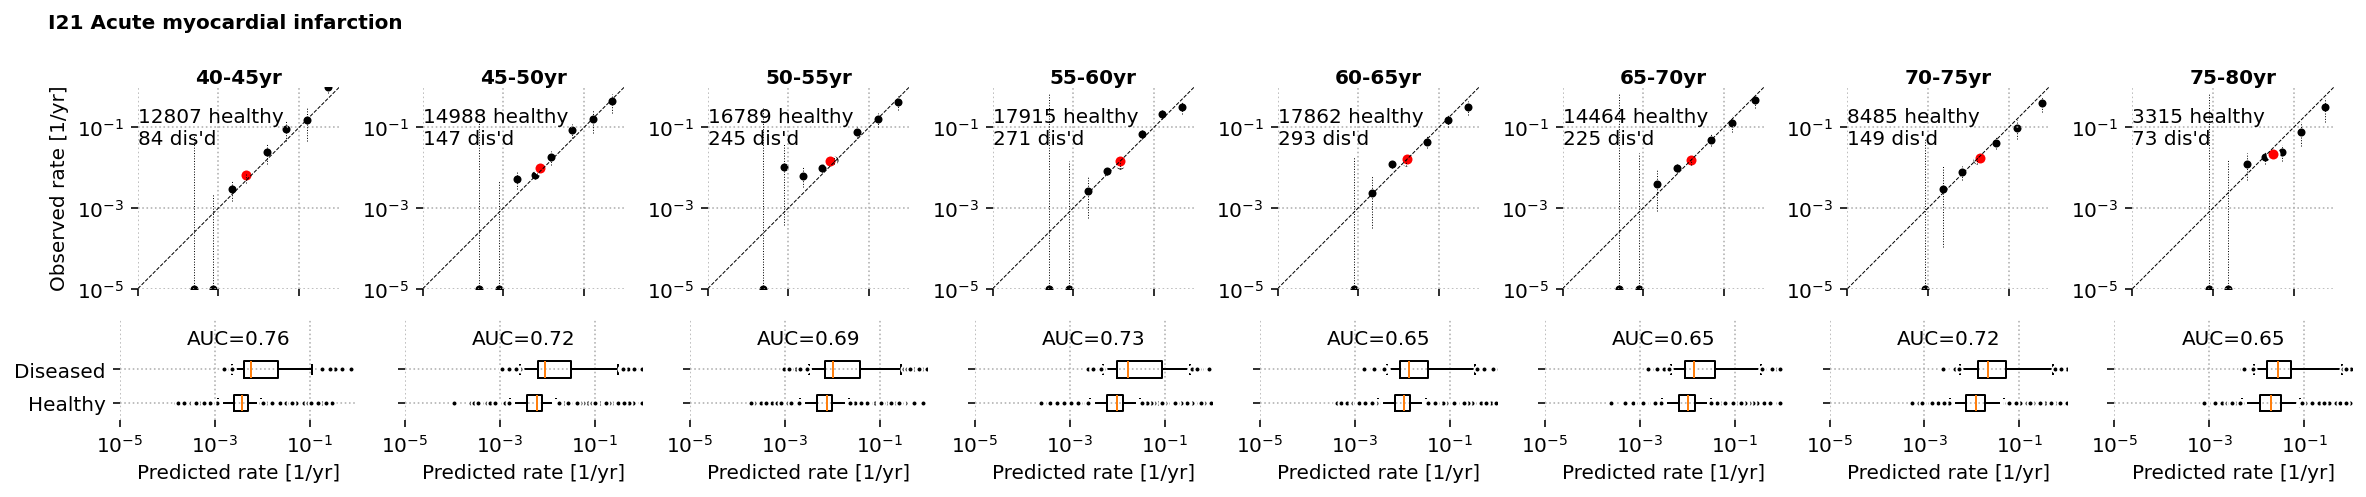

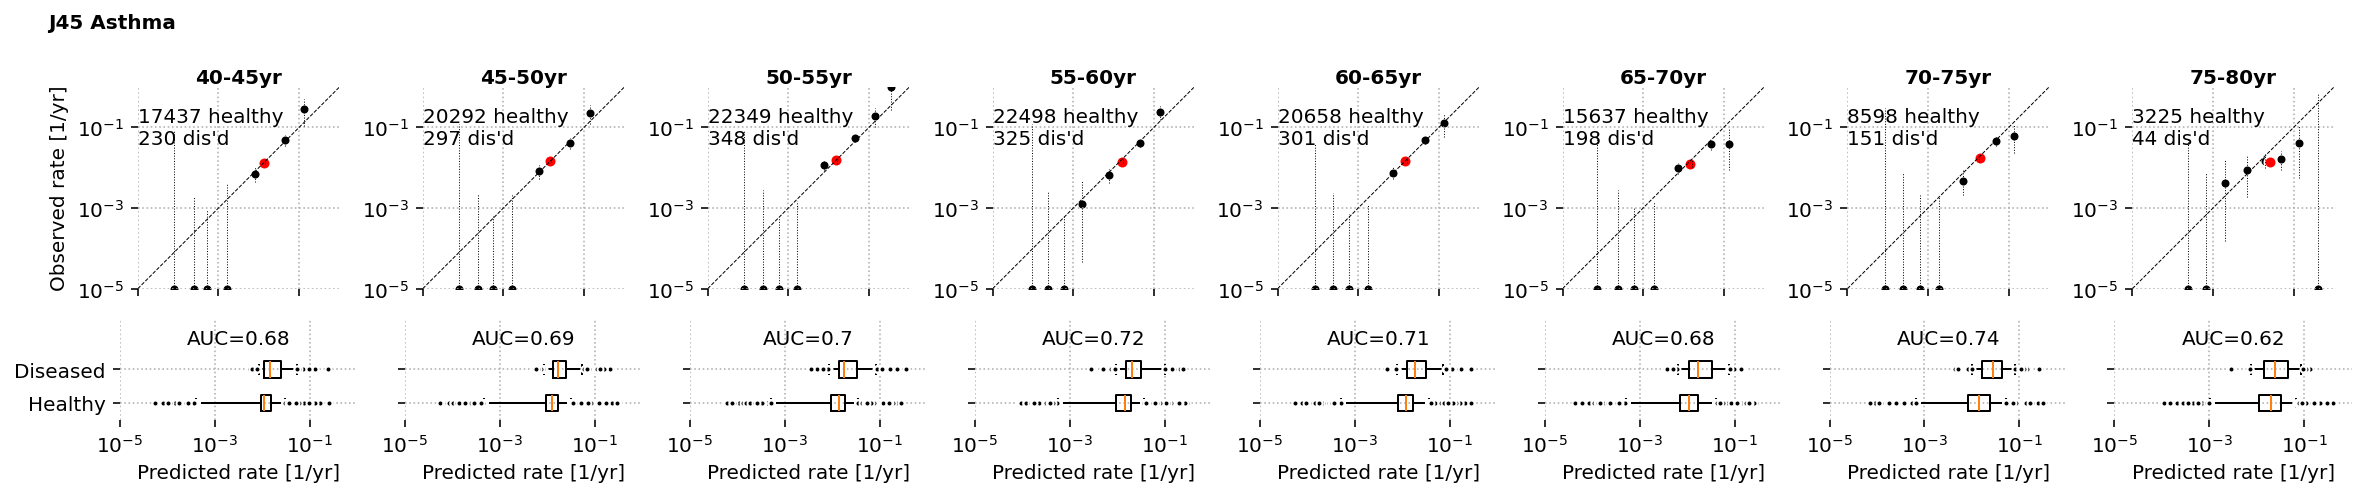

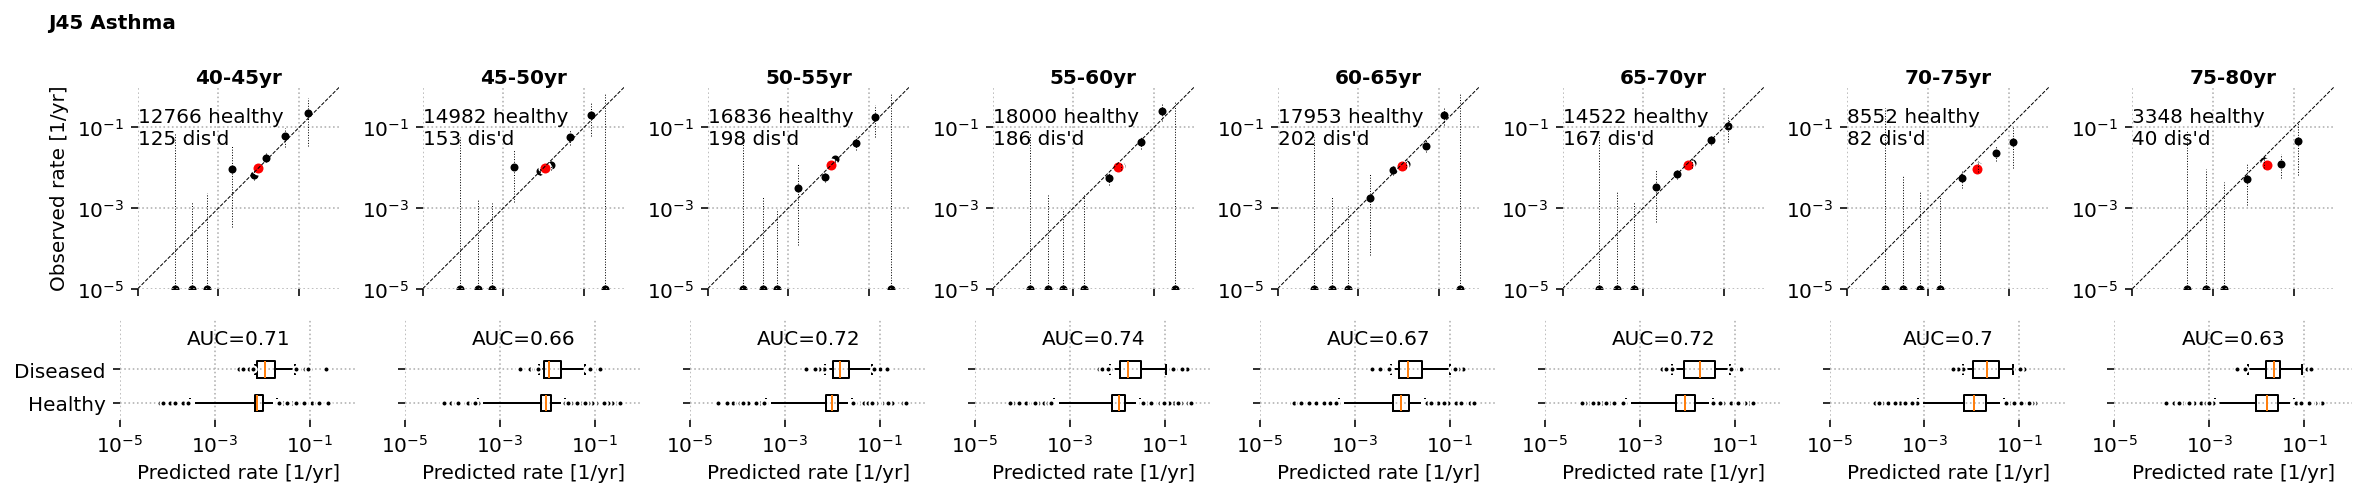

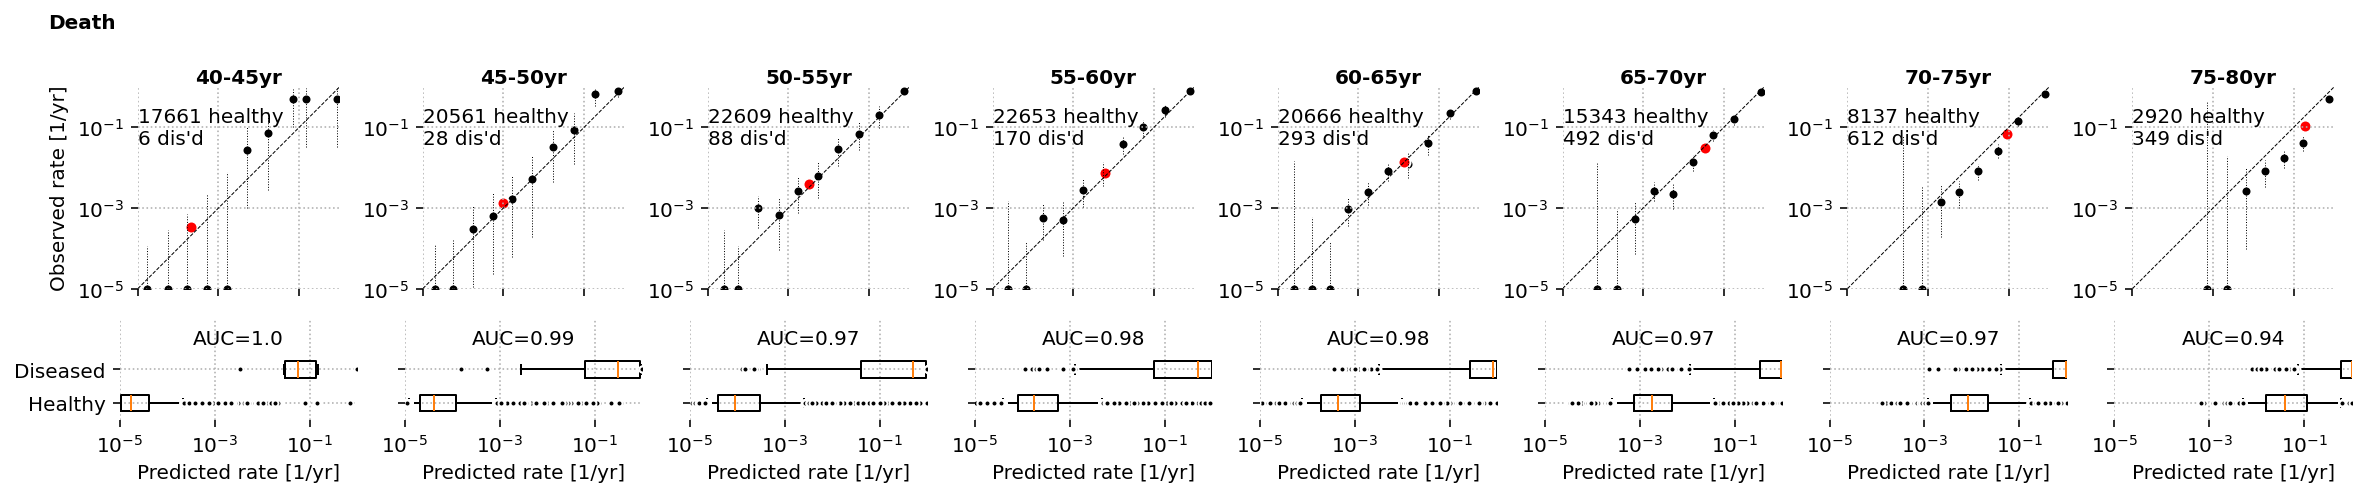

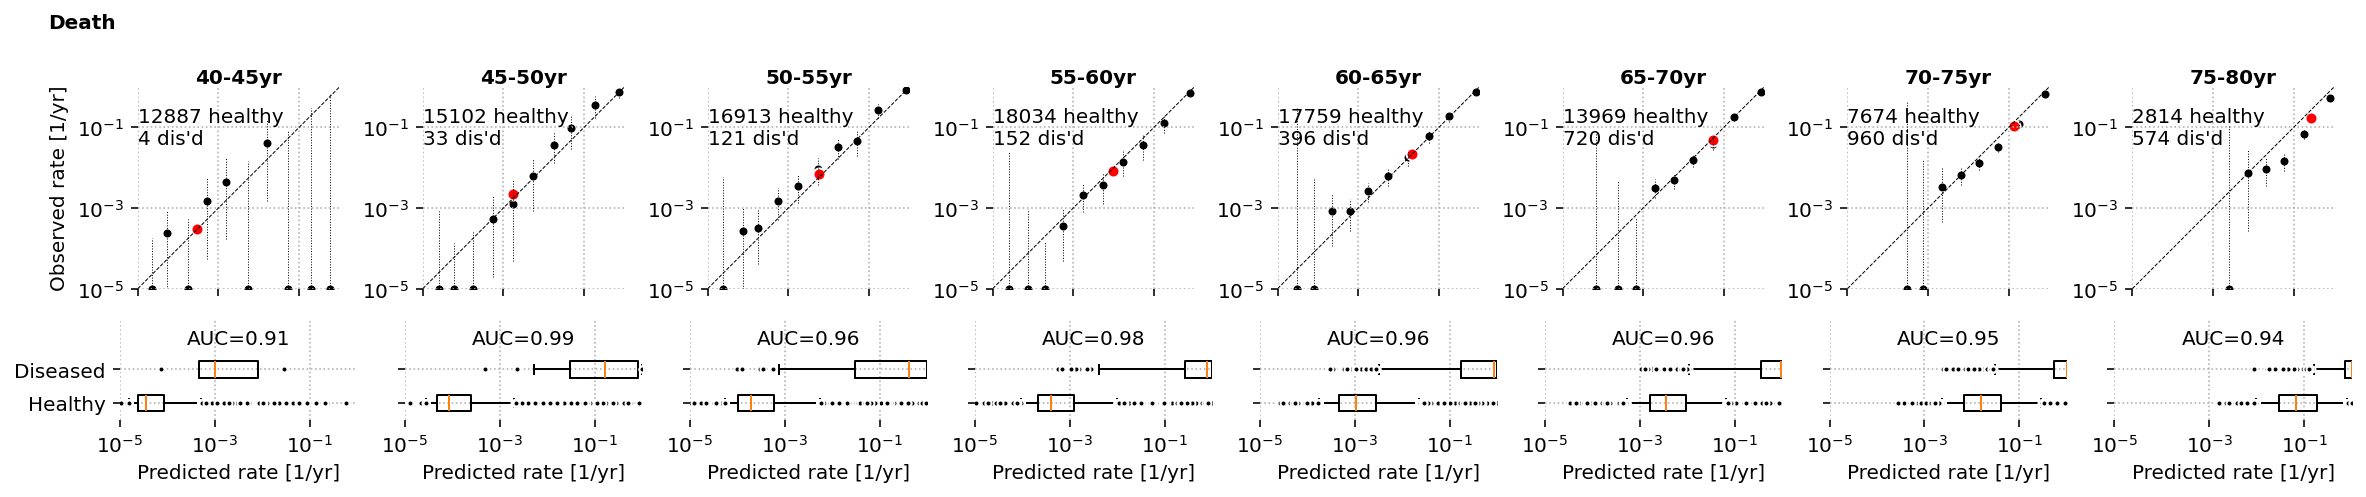

In [21]:
out = []
plt.rcParams.update({'figure.max_open_warning': 0})

is_male = (d100k[0] == 2).sum(1)>0
is_female = (d100k[0] == 3).sum(1)>0

calibration_inputs = {
    'male':   {'data': [d_[is_male].cpu() for d_ in d100k],   'logits': p100k[is_male.cpu()]},
    'female': {'data': [d_[is_female].cpu() for d_ in d100k], 'logits': p100k[is_female.cpu()]}
}

for j, k in enumerate(diseases_of_interest):
    disease_name = delphi_labels.loc[k, 'name']
    for sex in ['male', 'female']:
        out.append(plot_calibration(k,calibration_inputs[sex]['data'], calibration_inputs[sex]['logits'][..., j], age_groups=np.arange(40,80,5), offset=0.1))
        # plt.tight_layout()
        plt.suptitle(disease_name, fontsize=10, weight='bold', ha='left', x=0.1, y=1.05)
        plt.show()

/ssd/a193o/39192841/cluster_tmp/ipykernel_2369468/3571769465.py:15: RuntimeWarning: invalid value encountered in divide
  ax[j].plot(cal[0], cal[1]**2/cal[1], label=f"{40+5*age_bracket_idx}-{40+5*(age_bracket_idx+1)}yrs", c=cmap(intensity))


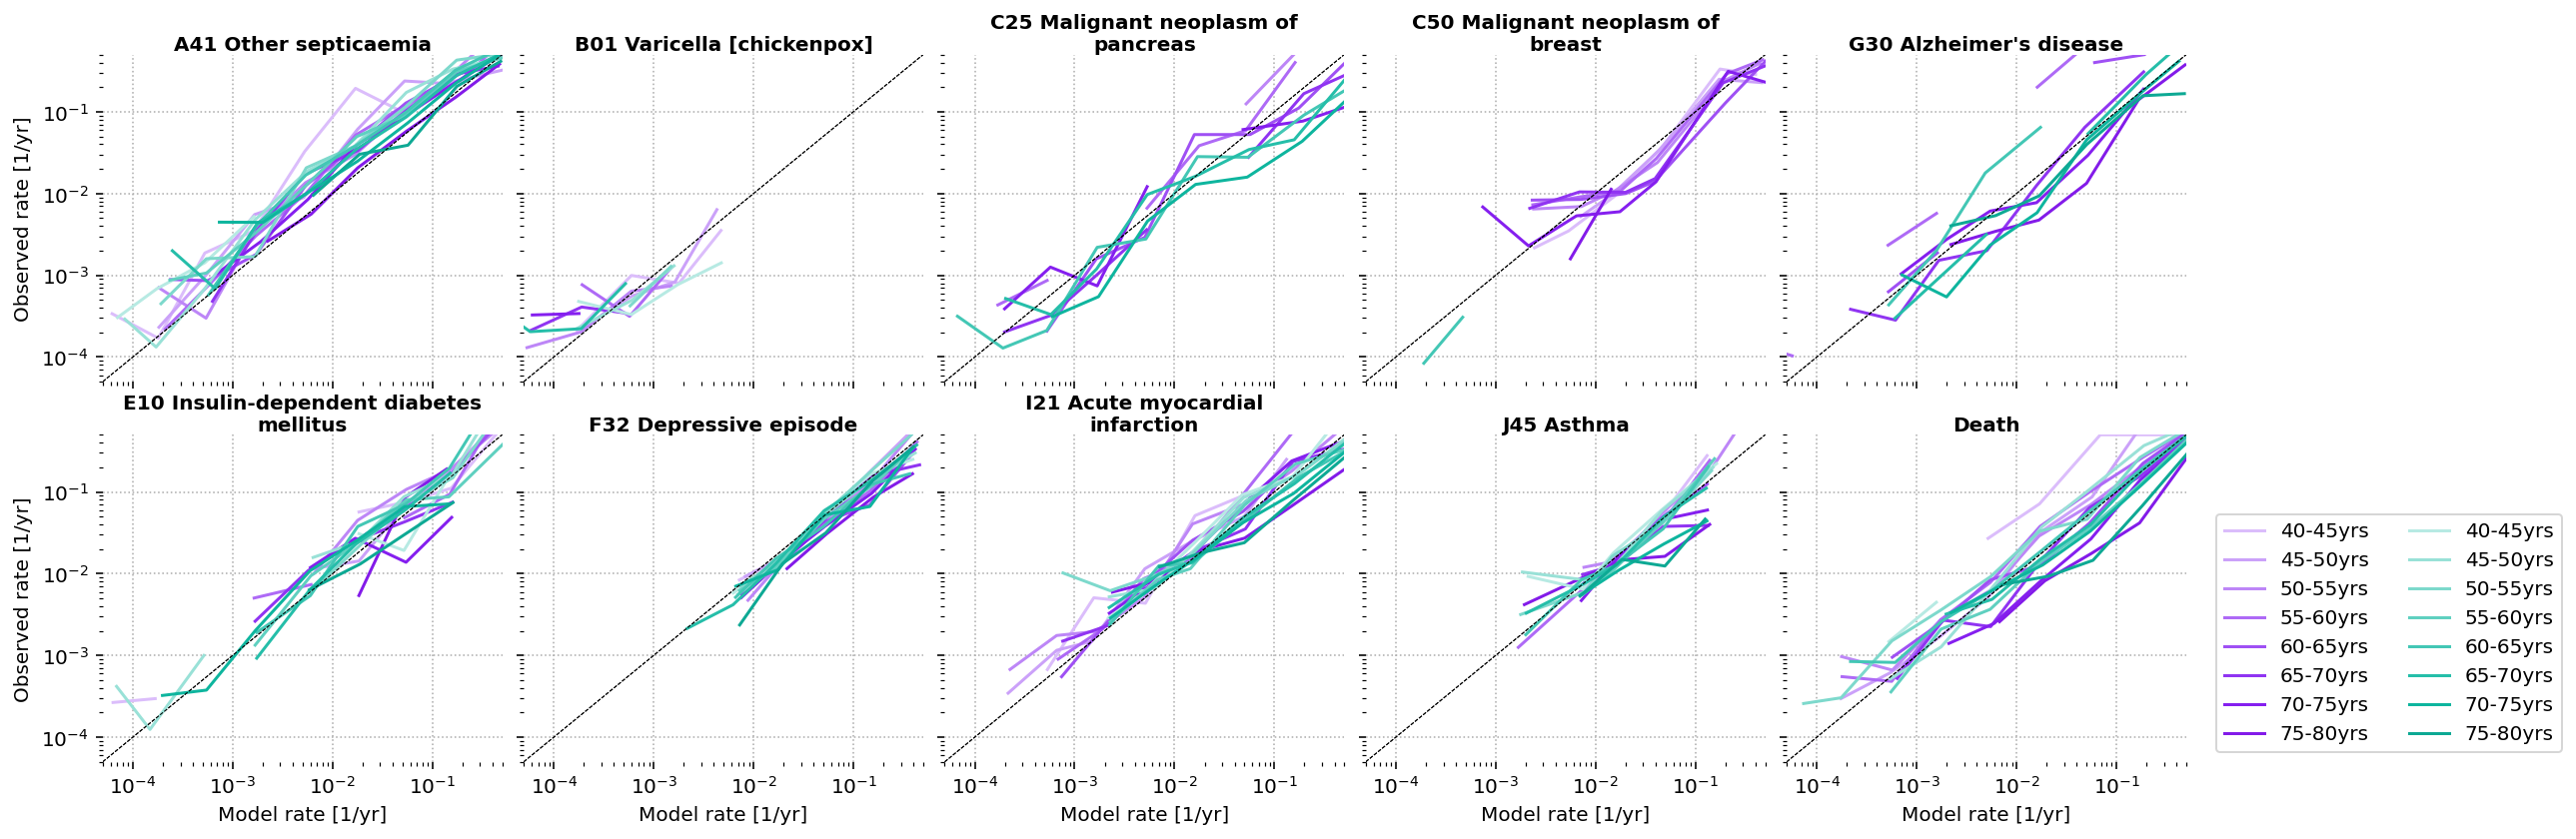

In [22]:
# the same calibrations curves as above, but a more compact version

from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(2,5,figsize=(18,6), sharex=True, sharey=True)
ax=ax.ravel()
for i, calibration_data in enumerate(out):
    j = i // 2 # Females and males
    is_male = i % 2 == 0
    for age_bracket_idx, cal in enumerate(calibration_data):
        if not isinstance(cal, list) and np.isnan(cal).all():
            continue
        intensity = 0.15+age_bracket_idx/9*.55
        cmap = LinearSegmentedColormap.from_list('cmap',list(zip([0,.5,1],[['white',normal_male,dark_male], ['white',normal_female,dark_female]][is_male])))
        ax[j].plot(cal[0], cal[1]**2/cal[1], label=f"{40+5*age_bracket_idx}-{40+5*(age_bracket_idx+1)}yrs", c=cmap(intensity)) 
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].set_xlim(5e-5, 0.5)
    ax[j].set_ylim(5e-5, 0.5)
    ax[j].plot([0, 1], [0, 1], transform=ax[j].transAxes, lw=.5, c='k', ls="--")
    ax[j].set_title("\n".join(textwrap.wrap(delphi_labels['name'].iloc[diseases_of_interest[j]],30)),verticalalignment='top', size=10, weight='bold')
    ax[j].set_xlabel('Model rate [1/yr]')
    ax[j].set_ylabel('Observed rate [1/yr]')
    ax[j].label_outer()

ax[j].legend(loc='lower left', ncol=2, bbox_to_anchor=(1.05, 0))

plt.gcf().tight_layout(h_pad=0.5)
plt.show()

## AUC of disease prediction

For evaluation of the AUCs, we use a similar strategy as in the calibration assesment.

1. Run Delphi for the entire dataset
2. Stratify all participants into sex & age groups - this is needed to regress out the "baseline" disease rate change - it's not that difficult to predict that older people have higher disease risk (for most diseases)
3. For each age-sex group, select controls and cases
4. Calculate the AUC using Delphi disease rates as predictors
5. (Optional) Use DeLong's method (recommended) or bootstrap to calculate the variance of the AUC

In [23]:
from evaluate_auc import get_calibration_auc, evaluate_auc_pipeline

offset = 0.1
pred_idx_precompute = (d100k[1][:, :, np.newaxis] < d100k[3][:, np.newaxis, :] - offset).to(torch.float32).sum(1) - 1 # float comvertion saves memory (somehow)
pred_idx_precompute = pred_idx_precompute.to(torch.int32)

is_male = (d100k[0] == 2).sum(1)>0
is_female = (d100k[0] == 3).sum(1)>0

auc_inputs = {
    'male':   {
               'data': [d_[is_male].cpu().numpy() for d_ in d100k],
               'logits': p100k[is_male.cpu()],   
               'pred_idx_precompute': pred_idx_precompute[is_male].cpu().numpy()
              },
    'female': {
               'data': [d_[is_female].cpu().numpy() for d_ in d100k], 
               'logits': p100k[is_female.cpu()], 
               'pred_idx_precompute': pred_idx_precompute[is_female].cpu().numpy()
              }
}

In [24]:
all_aucs = []

for disease_idx_batch, disease_idx in tqdm(enumerate(diseases_of_interest), total=len(diseases_of_interest)):
    for sex in ['male', 'female']:

        out = get_calibration_auc(
                    disease_idx_batch,
                    disease_idx,
                    auc_inputs[sex]['data'],
                    auc_inputs[sex]['logits'],
                    age_groups=np.arange(40, 80, 5),
                    offset=offset,
                    precomputed_idx=auc_inputs[sex]['pred_idx_precompute'],
                    use_delong=True,
                )
        
        if out is None:
            continue
        for out_item in out:
            out_item["sex"] = sex
            all_aucs.append(out_item)

 10%|███████▏                                                                | 1/10 [00:06<00:54,  6.05s/it]/omics/odcf/analysis/OE0606_projects_temp/pancancer_histopathology/art1m/Delphi-test/Delphi_revision_2/evaluate_auc.py:169: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


In [25]:
# this df contains AUC calculations for all diseases, sexes, and age groups
# to get the AUC for a specific disease, one needs to aggregate over the age groups and sexes
# however, while for the mean AUC this is straightforward, it's a bit more complicated for the variance
# as Delong's method provides confidence intervals as the form of variance of a normal distribution
# we can use the closed form of the variance of the mean of a normal distributions to get the variance of the AUC
# let's defile a custom funciton for it

def aggregate_normals(group):
    # For normal distributions, when averaging them:
    # The mean is the weighted average of means
    # The variance of the sum is the sum of variances
    # The variance of the average is the sum of variances divided by n^2
    n = len(group)
    mean = group['auc_delong'].mean()
    # Since we're taking the average, divide combined variance by n^2
    var = group['auc_variance_delong'].sum() / (n**2)
    return pd.Series({
        'auc': mean,
        'auc_variance_delong': var,
        'n_samples': n, 
        'n_diseased': group['n_diseased'].sum(),
        'n_healthy': group['n_healthy'].sum(),
    })


auc_df_all_brackets = pd.DataFrame(all_aucs)
auc_df = auc_df_all_brackets.groupby(['token']).apply(aggregate_normals, include_groups=False).reset_index()
auc_df = auc_df.merge(delphi_labels[['name', 'index']], left_on='token', right_on='index', how='inner')
auc_df

token       auc  auc_variance_delong  n_samples  n_diseased  n_healthy  \
0     46  0.852000             0.000044       16.0      2634.0   398495.0   
1     95  0.688512             0.000464       15.0       144.0   393582.0   
2    214  0.929106             0.000052       16.0       780.0   408521.0   
3    305  0.696939             0.000015       16.0      7856.0   360873.0   
4    374  0.737556             0.000349       13.0       452.0   293739.0   
5    505  0.653721             0.000036       16.0      3950.0   390301.0   
6    603  0.616592             0.000025       16.0      6588.0   350471.0   
7   1168  0.812352             0.000971       14.0       163.0   337114.0   
8   1188  0.659735             0.000865       16.0      2736.0   399089.0   
9   1269  0.942612             0.000009       16.0      5977.0   380961.0   

                                      name  index  
0                    A41 Other septicaemia     46  
1               B01 Varicella [chickenpox]     95  
2  E10 Insulin-dependent diabetes mellitus    214  
3                   F32 Depressive episode    305  
4                  G30 Alzheimer's disease    374  
5          I21 Acute myocardial infarction    505  
6                               J45 Asthma    603  
7       C25 Malignant neoplasm of pancreas   1168  
8         C50 Malignant neoplasm of breast   1188  
9                                    Death   1269

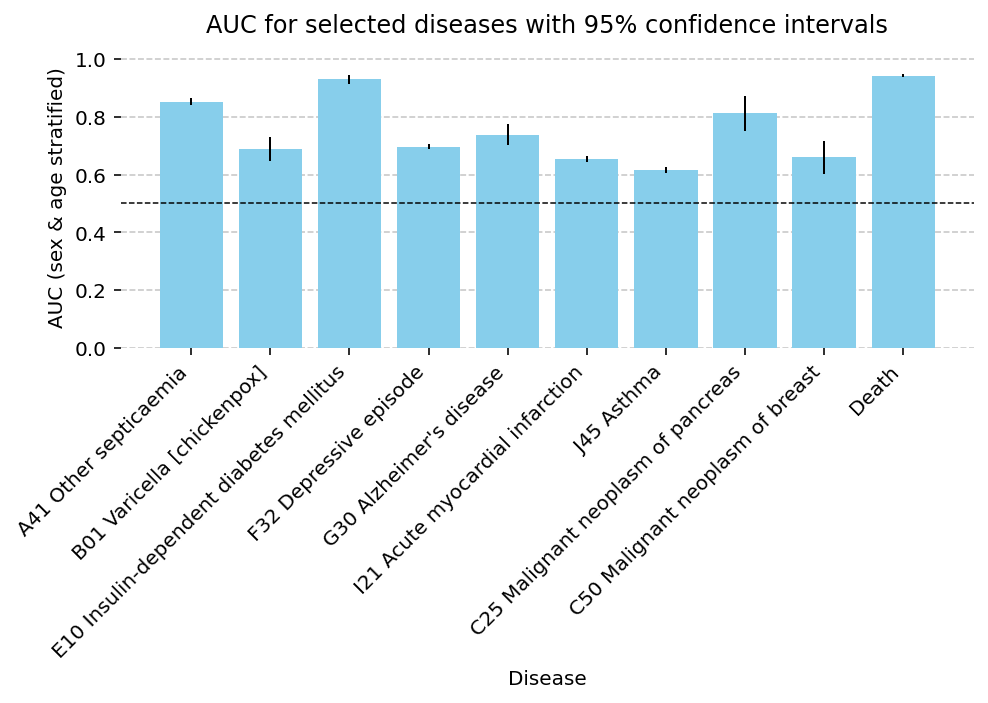

In [26]:
plt.figure(figsize=(7, 5))

# Create the bar chart
bars = plt.bar(range(len(auc_df)), auc_df['auc'], color='skyblue')

plt.errorbar(
    range(len(auc_df)), 
    auc_df['auc'], 
    yerr=1.96 * np.sqrt(auc_df['auc_variance_delong']),
    fmt='none', 
    color='black', 
    capsize=0,
    linewidth=1.0,
)

# Add labels and title
plt.xlabel('Disease')
plt.ylabel('AUC (sex & age stratified)')
plt.title('AUC for selected diseases with 95% confidence intervals')
plt.xticks(range(len(auc_df)), auc_df['name'], rotation=45, ha='right')
plt.gca().set_axisbelow(True)
plt.grid(axis='x', visible=False)
plt.axhline(0.5, color='k', linestyle='--', linewidth=0.75)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()


## AUC for the entire disease set

Auc can be evaluated for all diseases, but it would take about 30 minutes to run for 100k trajectories with a gpu; much londer with a cpu.

Therefore, we well use precomputed results here. 

In [27]:

# df_auc_unpooled_merged, df_auc_merged = evaluate_auc_pipeline(model, 
#                                                        d100k,
#                                                        output_path=None,
#                                                        delphi_labels=delphi_labels[13:].index.values,
#                                                        diseases_of_interest=diseases_of_interest,
#                                                        filter_min_total=100, # remove rare diseases
#                                                        device=device,
#                                                        )


In [28]:
df_auc_all_diseases = pd.read_csv('supplementary/delphi_auc.csv')
df_auc_all_diseases['mean_auc'] = df_auc_all_diseases[['AUC Female, (no gap)', 'AUC Male, (no gap)']].mean(axis=1)

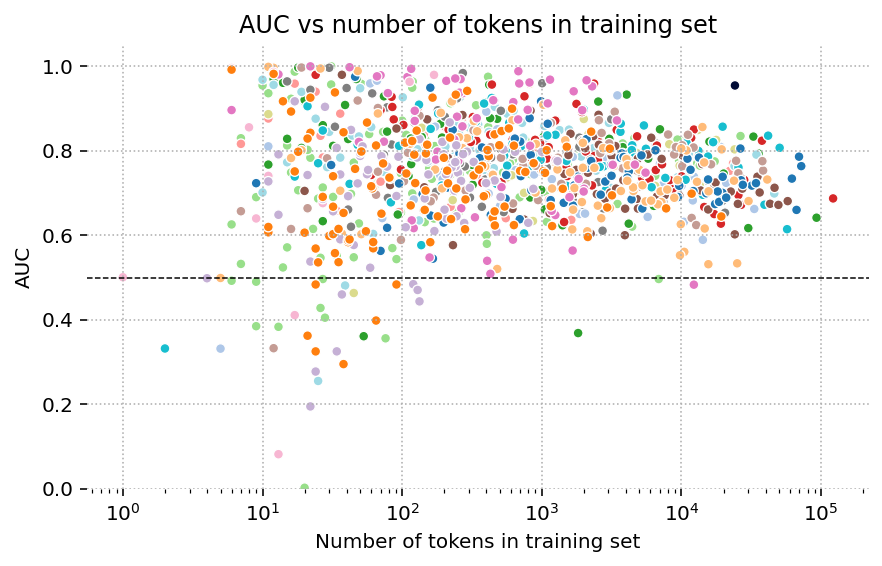

In [29]:
plt.figure(figsize=(7, 4))
plt.scatter(df_auc_all_diseases['N tokens, training'], df_auc_all_diseases['mean_auc'], 
            c=df_auc_all_diseases['Colour'], s=24, edgecolor='white', linewidth=0.65)
plt.axhline(0.5, color='k', linestyle='--', linewidth=0.75)
plt.title('AUC vs number of tokens in training set')
plt.xscale('log')
plt.ylim(0, 1.05)
plt.xlabel('Number of tokens in training set')
plt.ylabel('AUC')
plt.show()


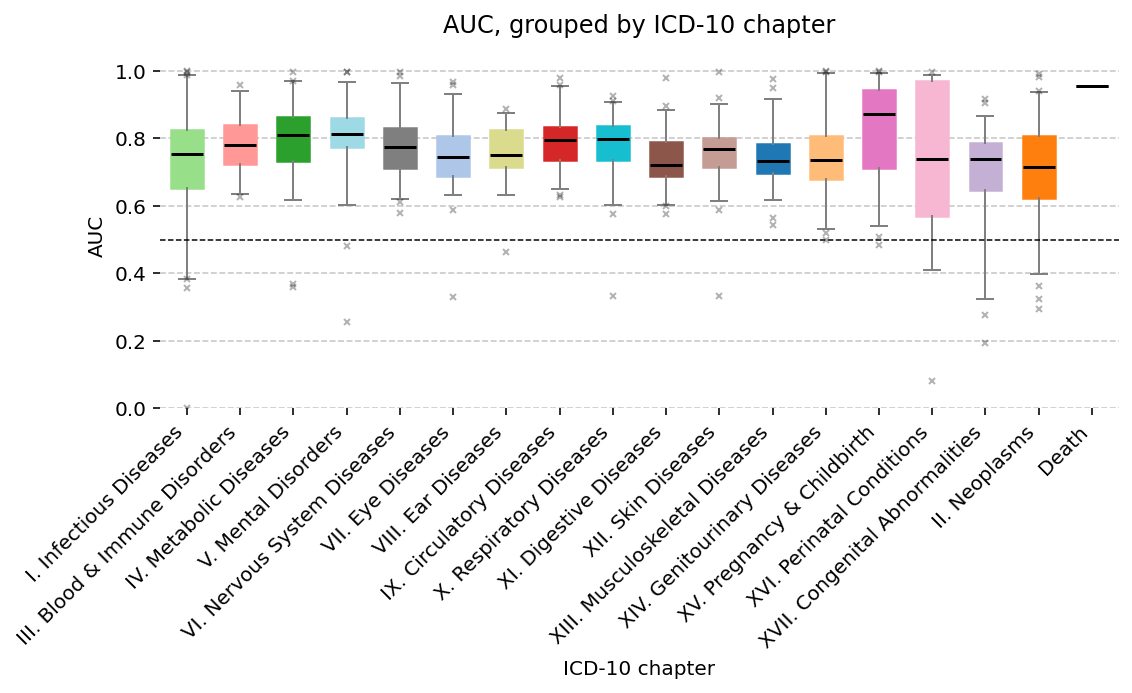

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

filtered_df = df_auc_all_diseases.dropna(subset=['mean_auc'])

chapters = filtered_df['ICD-10 Chapter (short)'].unique()
chapter_data = {}

for chapter in chapters:
    if chapter not in ['Technical', 'Sex', 'Smoking, Alcohol and BMI']:  # Skip non-disease chapters
        chapter_data[chapter] = filtered_df[filtered_df['ICD-10 Chapter (short)'] == chapter]['mean_auc'].values

fig, ax = plt.subplots(figsize=(8, 5))

chapter_colors = {}
for chapter in chapter_data.keys():
    chapter_rows = filtered_df[filtered_df['ICD-10 Chapter (short)'] == chapter]
    chapter_colors[chapter] = chapter_rows['Colour'].iloc[0]

positions = np.arange(1, len(chapter_data) + 1)
boxplots = []

for i, (chapter, values) in enumerate(chapter_data.items()):
    bp = ax.boxplot(values, positions=[positions[i]], patch_artist=True, 
                   widths=0.6, whis=[2.5, 97.5], showfliers=True, 
                   boxprops={'linewidth': 1.25, 'facecolor': chapter_colors[chapter], 
                             'edgecolor': chapter_colors[chapter]},
                   medianprops={'color': 'black', 'linewidth': 1.5},
                   whiskerprops={'color': 'gray', 'linewidth': 1},
                   capprops={'color': 'gray', 'linewidth': 1},
                   flierprops={'marker': 'x', 'markerfacecolor': 'none', 
                              'markeredgecolor': 'black', 'markersize': 3, 'alpha': 0.3})

    boxplots.append(bp)

ax.set_xticks(positions)
ax.set_xticklabels([chapter for chapter in chapter_data.keys()], rotation=45, ha='right')

ax.set_ylim(0, 1.025)
ax.axhline(0.5, color='black', linestyle='--', linewidth=0.75)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

ax.set_ylabel('AUC')
ax.set_xlabel('ICD-10 chapter')
ax.set_title('AUC, grouped by ICD-10 chapter', y=1.05)

plt.tight_layout()
plt.grid(axis='x', visible=False)
plt.show()

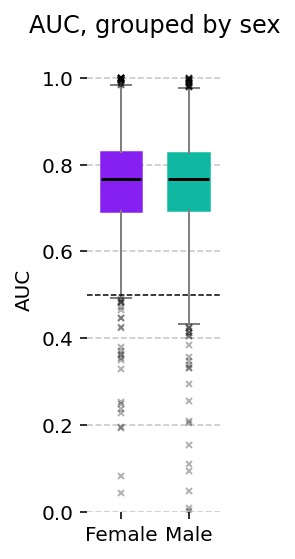

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Filter out rows with NaN values in mean_auc
filtered_df = df_auc_all_diseases.dropna(subset=['mean_auc'])

# Create separate data for males and females
male_data = filtered_df[filtered_df['AUC Male, (no gap)'].notna()]['AUC Male, (no gap)'].values
female_data = filtered_df[filtered_df['AUC Female, (no gap)'].notna()]['AUC Female, (no gap)'].values

# Set up the figure
fig, ax = plt.subplots(figsize=(1.75, 4))

# Define colors for male and female
male_color = normal_male
female_color = normal_female

# Create boxplots
positions = [1, 2]
boxplots = []

# Create boxplots for both sexes using a loop
sex_data = [female_data, male_data]
sex_colors = [female_color, male_color]
sex_labels = ['Female', 'Male']

for i in range(2):
    bp = ax.boxplot(sex_data[i], positions=[positions[i]], patch_artist=True, 
                widths=0.6, whis=[2.5, 97.5], showfliers=True, 
                boxprops={'linewidth': 1.25, 'facecolor': sex_colors[i], 
                          'edgecolor': sex_colors[i]},
                medianprops={'color': 'black', 'linewidth': 1.5},
                whiskerprops={'color': 'gray', 'linewidth': 1},
                capprops={'color': 'gray', 'linewidth': 1},
                flierprops={'marker': 'x', 'markerfacecolor': 'none', 
                           'markeredgecolor': 'black', 'markersize': 3, 'alpha': 0.3})
    boxplots.append(bp)

# Set x-axis labels
ax.set_xticks(positions)
ax.set_xticklabels(sex_labels)

# Set y-axis limits and add reference line
ax.set_ylim(0, 1.025)
ax.axhline(0.5, color='black', linestyle='--', linewidth=0.75)

# Add grid for y-axis only
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add labels and title
ax.set_ylabel('AUC')
ax.set_title('AUC, grouped by sex', y=1.05)

# Adjust layout
plt.tight_layout()
plt.grid(axis='x', visible=False)

plt.show()

## Interpretability

### Attention maps

Being a transformer model, Delphi uses attention to aggregate information from the input tokens. Here, we plot the attention matrices for all heads and layers for a single trajectory.

Note how different heads and layers attend to different parts of the input trajectory.

Attention maps can be used for interpretability, however for a more robust interpretation, we suggest using SHAP values (`shap_analysis.ipynb`).

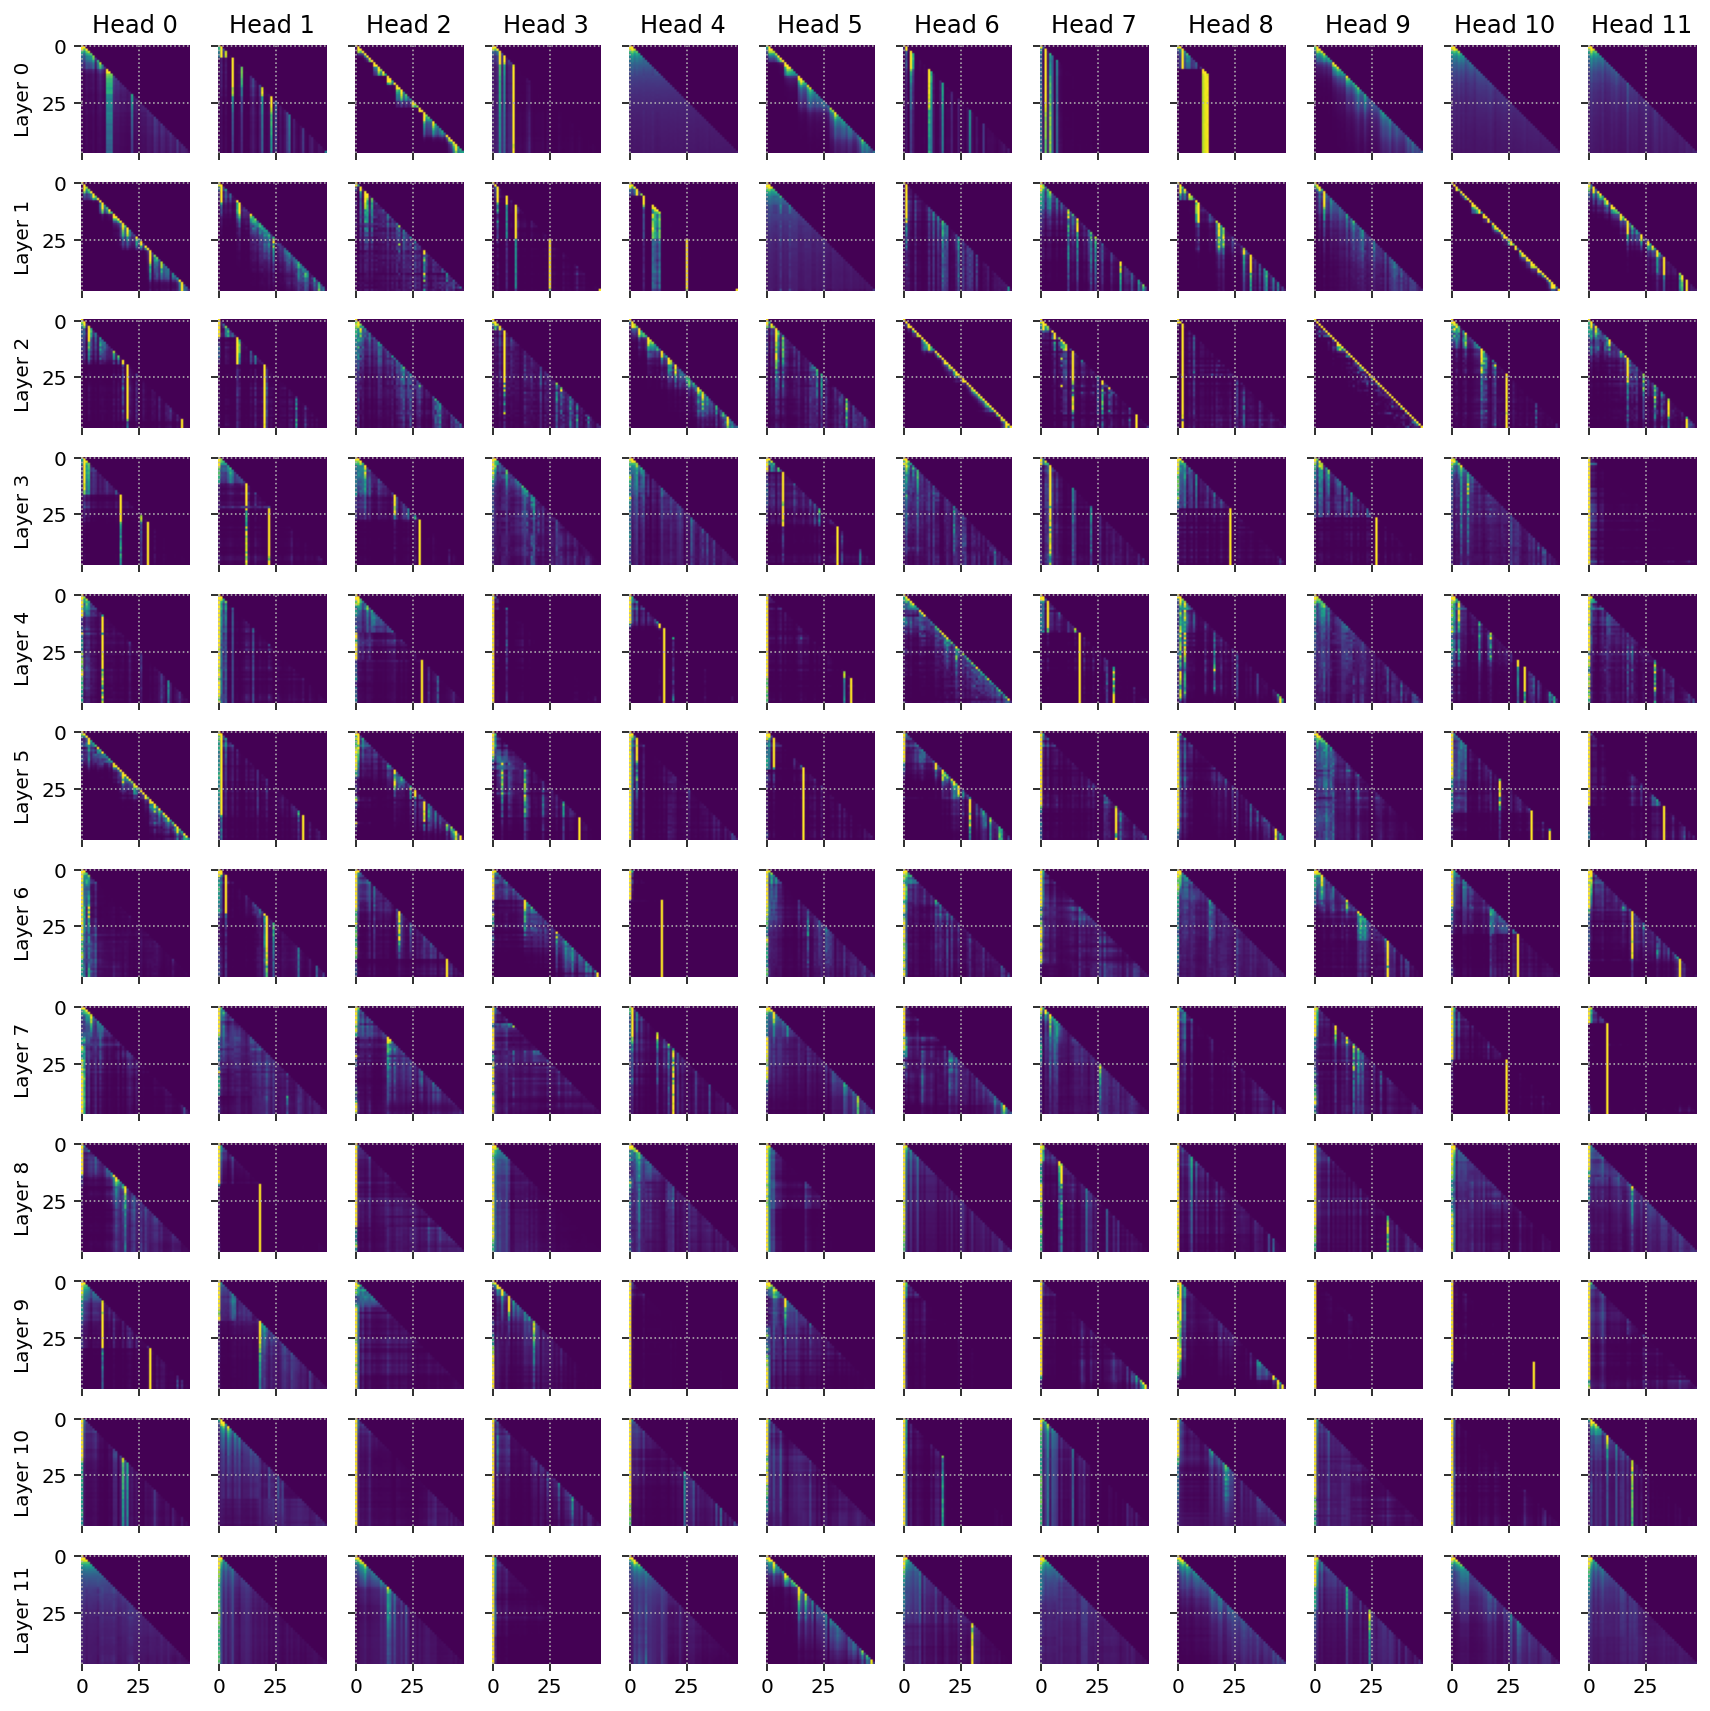

In [32]:
d = get_batch([0], val, val_p2i, select='left', block_size=model.config.block_size, device=device)

risk = np.exp(model(d[0],d[1])[0].cpu().detach().numpy().squeeze())
att = model(d[0],d[1])[2].cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(*att.shape[:2], figsize=(12,12), sharex=True, sharey=True)
for i in range(att.shape[0]):
    for j in range(att.shape[1]):
        ax[i,j].imshow(att[i,j], vmax=0.35)
        if i==0:
            ax[i,j].set_title(f"Head {j}")
        if j==0:
            ax[i,j].set_ylabel(f"Layer {i}")
plt.tight_layout()

In [33]:
d = get_batch(range(dataset_subset_size), val, val_p2i,  
              select='left', block_size=48, 
              device=device, padding='random')
w = np.where(torch.isin(d[2].cpu(), torch.tensor(diseases_of_interest)).sum(axis=1))
w = (w[0][:3],)
att = model(*list(map(lambda x: x[w[0],:], d)))[2].cpu().detach().numpy().squeeze()
att.shape

(12, 3, 12, 48, 48)

We can also plot average attention across all heads and layers to see which tokens are attended to most "on average".

Generally, tokens tend to lose most of their importance pretty quickly. High attention for the most recent token in the trajectory is likely due to this tokens being used by the model to estimate the current age of the patient, which is a very important predictor for the overall disease risk.

0


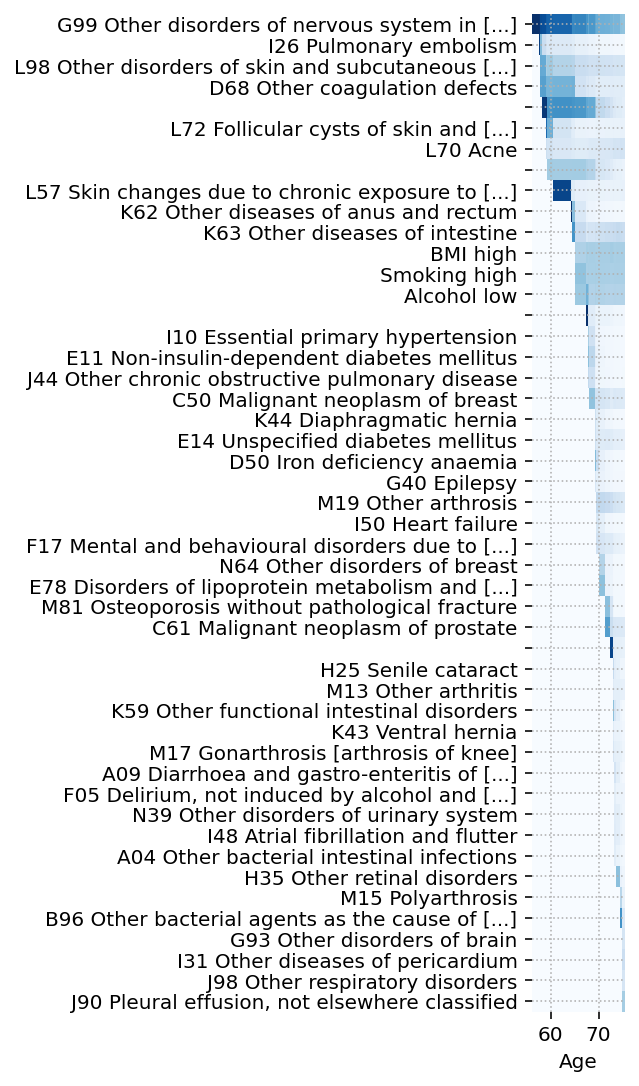

1


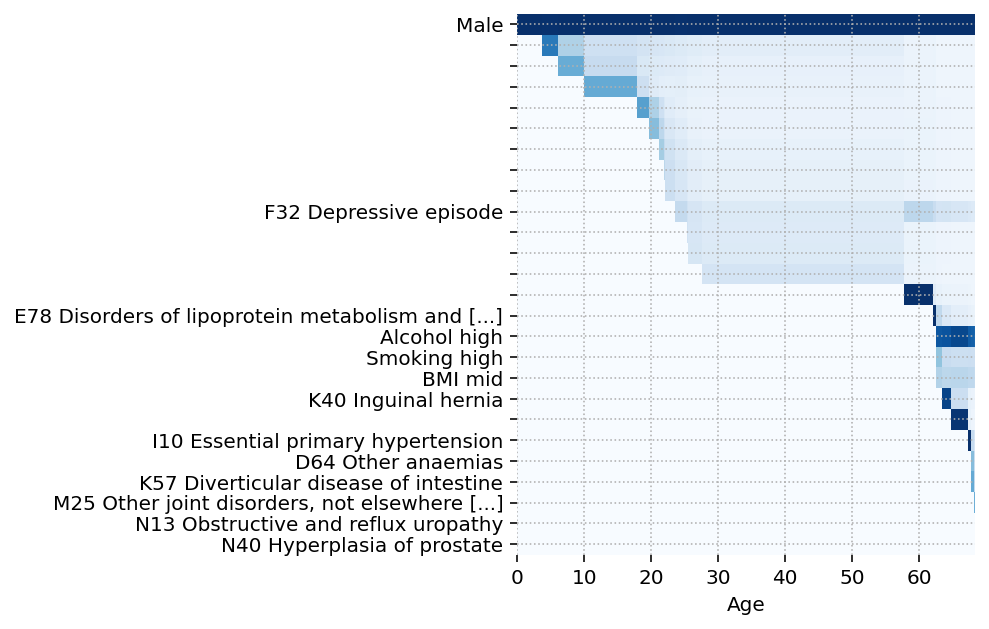

2


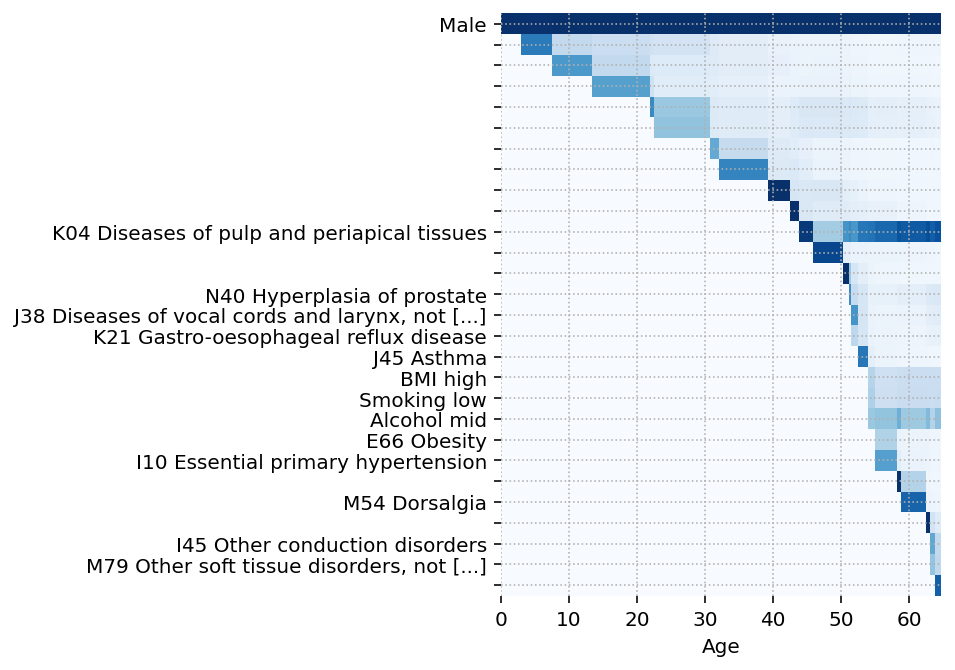

In [34]:
import textwrap

d = [d_.cpu() for d_ in d]

for i in range(len(w[0])):
    print(i)
    j = (d[0][w[0][i]]==0).sum()
    plt.figure(figsize=(3 * (d[3][w[0][i],-1]-d[1][w[0][i],0])/365.25/70,9 * (48-j)/48))
    x = torch.concatenate([d[1][w[0][i]], d[3][w[0][i],[-1]]])/365.25
    plt.pcolormesh( x[j:],np.arange(j,49,1), att[0,i,:,j:,j:].max((0)).T, cmap='Blues')
    _ = plt.yticks(np.arange(j,48)+.5, [f"{textwrap.shorten(delphi_labels.loc[i,'name'],50)}" if i > 1 else "" for i,t in zip(d[0][w[0][i],j:].detach().numpy().squeeze(),d[1][w[0][i],j:].detach().numpy().squeeze()/365.25)])
    plt.gca().invert_yaxis()
    plt.xlabel('Age')
    plt.show()

## Embeddings

Lastly, it's interesting to look into the learned latent space of the model.

Here, we plot the UMAP of the learned disease embeddings.

We see that diseases cluster by their ICD-10 chapter - which is interesting, because the model had no knowledge about the ICD-10 hierarchy during training; all diseases were treated equally. 

In [35]:
import umap
import matplotlib as mpl

/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
wte = model.transformer.wte.weight.cpu().detach().numpy()
seed = 1413
t  = umap.UMAP(random_state=seed, n_neighbors=30, min_dist=0.05, metric='cosine').fit(wte)

u0 = t.transform(model.transformer.wte.weight.cpu().detach().numpy())
u = u0 - np.median(u0, axis=0)
u = - u

/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [37]:
def remove_ticks(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

In [38]:
labels_all = pd.read_csv('delphi_labels_chapters_colours_icd.csv')
labels_all['UMAP1'] =  u[:,0]
labels_all['UMAP2'] =  u[:,1]
labels_all = labels_all[labels_all['count'] > 20].reset_index(drop=True).reset_index()
labels_non_technical = labels_all[~labels_all['ICD-10 Chapter'].isin(['Technical', 'Sex', 'Smoking, Alcohol and BMI'])]
labels_non_technical = labels_non_technical[(labels_non_technical['UMAP1'].abs() < 5) & (labels_non_technical['UMAP2'].abs() < 5)]
short_names = labels_all['ICD-10 Chapter (short)'].unique()
short_names_present = [i for i in short_names if i in labels_non_technical['ICD-10 Chapter (short)'].unique()]
color_mapping_short = {k: v for k, v in labels_all[['ICD-10 Chapter (short)', 'color']].values}

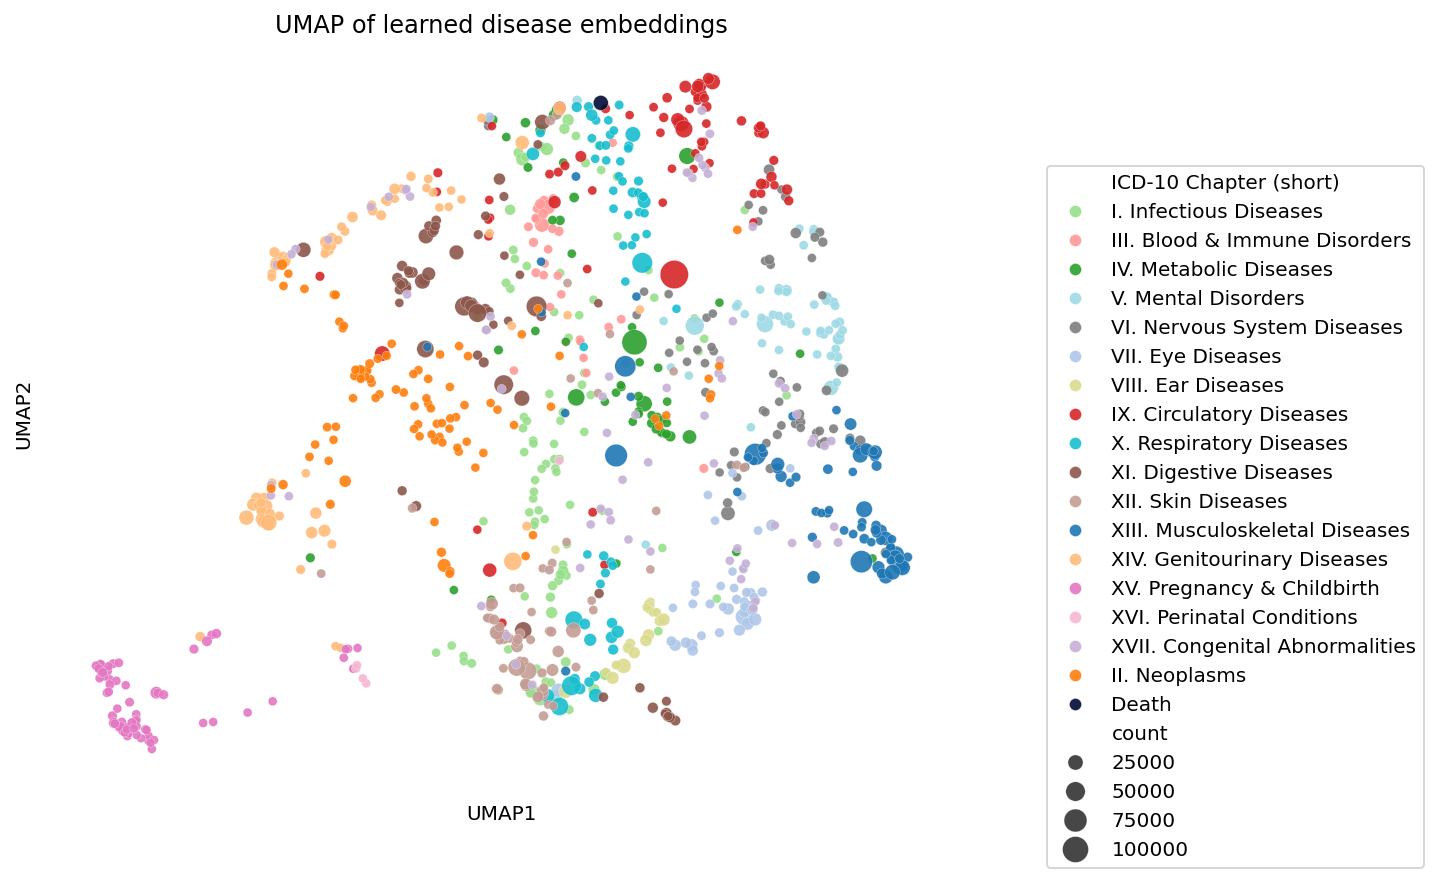

In [39]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x='UMAP1', y='UMAP2', data=labels_non_technical, hue='ICD-10 Chapter (short)', 
                palette=color_mapping_short, 
                hue_order=short_names_present, size='count', sizes=(20, 200), 
                alpha=0.9, ax=ax, linewidth=0.15)

ax.legend_.set_bbox_to_anchor((1.1, 0.85))
ax.grid(None)
remove_ticks(ax)
ax.set_aspect('equal')
plt.title('UMAP of learned disease embeddings');

## The End!

If you want to learn more about Delphi, check out the `shap_analysis.ipynb` notebook next, where we use SHAP values to interpret the model's predictions.